# **Compare MGI 3' sequencing to BGI paired-end RNA-seq**

<b> Author: </b> Anna H.C. Vlot <br>
<b> Date: </b> 03-Nov-2023, final check on 06-Nov-2023 <br>

<b> Data: </b> 3' counts and UMIs and paired-end sequencing raw counts and TPMs for a single plate of _D. rerio_ data. Importantly, this plate is extraction batch 1, for which poor data quality was observed. <br>
<b> Goal: </b> Check whether 3' sequencing is comparable to standard RNA-seq for detection of transcriptromic changes upon chemical exposure.

In [1]:
import os
import numpy as np
import pandas as pd
from math import ceil

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import mantel
from scipy.spatial.distance import pdist
from scipy.stats import pearsonr

from gprofiler import GProfiler

from IPython.display import Markdown, display

from sklearn.decomposition import PCA

In [2]:
def printmd(string):
    display(Markdown(string))

In [3]:
treatments = {'001': 'CdCl2 treatment',
              '002': 'ethoprop treatment',
              '003': 'pirinixic acid treatment',
              '004': 'DMSO treatment',
              '006': 'NaAsO2 treatment',
              '000': 'water control',
              '999': 'DMSO control'}

In [4]:
mgidir = '/nfs/users/project/precisiontox_008279/mgi_qc/data/external/'

pilotdir = '/nfs/users/project/precisiontox_008279/pilot/'
rnadir = './data/interim/danio/rnaseq/'
genomdir = './data/external/genomes/danrer11/'
cleandir = './data/final/danio/rnaseq/'
metadir = './data/external/metadata/'

## **Load data tables**

### **3' UMI**
STARsolo output

In [5]:
mgi_umi = pd.read_csv(mgidir + 'Danio_V350148104_1MM_umi.counts.txt',  # mapped to RefSeq
                        sep='\t', index_col=0)
mgi_umi.index.name = 'gene_id'
mgi_umi.shape

(47046, 96)

In [6]:
mgi_umi.head()

ExtBlnk1  RAA004MC3  RAB006MC3  RAA004LD1  RAB004MB6  RAA002LC1  \
gene_id                                                                    
rpl24          25       1648        615       1621       1438          1   
cep97           0          8          4          6          7          0   
nfkbiz          0         21          5         34         20          0   
eed             0         12          6          2          5          0   
hikeshi         0         23          8         30         35          0   

         RAA002MA6  RAA004LA1  RAB001MA2  RAA002LD6  ...  RAA999ZD4  \
gene_id                                              ...              
rpl24         1659       1745       1323       2098  ...          1   
cep97            6         14         15          7  ...          0   
nfkbiz          22         36         16         15  ...          0   
eed             11          8          5         16  ...          0   
hikeshi         21         22         15         42  ...          0   

         RAB006LB2  RAA002LD2  RAB000ZC5  RAA003MA3  RAB004LA2  RAA002LC2  \
gene_id                                                                     
rpl24         1491         30        429       1441       1303        830   
cep97           10          0          3          9         12          3   
nfkbiz           7          0          2          7         26         13   
eed             10          0          1         11          6          5   
hikeshi         21          1          6         24         12         19   

         RAA999ZB4  RAB000ZA3  RAA002MC4  
gene_id                                   
rpl24         1387       1810       1453  
cep97            8          9          7  
nfkbiz          13         25         13  
eed              6          6          8  
hikeshi         25         36         36  

[5 rows x 96 columns]

### **3' counts**
STARsolo alignment with featureCounts quantification

In [7]:
mgi_counts = pd.read_csv(mgidir + 'Danio_V350148104_read_counts.txt',
                         sep='\t', index_col=0, skiprows=1)
mgi_counts = mgi_counts.iloc[:, 5:]
mgi_counts.columns =[i.split('//')[1].split('.')[0] for i in mgi_counts.columns]
mgi_counts.index.name = 'gene_id'
mgi_counts.shape

(47048, 96)

In [8]:
mgi_counts.head()

Blank_1_1  Blank_1_2  Blank_1_3  Blank_1_4  ExtBlnk1  \
gene_id                                                         
rpl24            0        360        931        483       115   
cep97            0          1          0          0         0   
nfkbiz           0          1          2          5         0   
eed              0          0          1         15         0   
hikeshi          0          0          1          4         0   

         Lib_Negative_1-1  Lib_Negative_1-2  Lib_Negative_1-3  \
gene_id                                                         
rpl24                 138                36               147   
cep97                   1                 0                 0   
nfkbiz                  0                 0                 6   
eed                     0                 0                 0   
hikeshi                 0                 0                 0   

         Lib_Negative_1-4  Lib_Positive_1-1  ...  RAB006LC4  RAB006LC6  \
gene_id                                      ...                         
rpl24                 168              6124  ...      10637       6575   
cep97                   0                21  ...         32         32   
nfkbiz                  0                88  ...         47         59   
eed                     0                73  ...         59          6   
hikeshi                 0                94  ...        123         21   

         RAB006LD2  RAB006MA2  RAB006MA6  RAB006MB2  RAB006MC1  RAB006MC3  \
gene_id                                                                     
rpl24        14820       4471       3660       4760      18825       4801   
cep97           90         15         16         14          7         23   
nfkbiz          27          1         11         54         20         26   
eed             93         47         40         29        155         40   
hikeshi        235         40         62         64        196         31   

         RAB006MD1  RAB006MD2  
gene_id                        
rpl24        14935      10844  
cep97           84         24  
nfkbiz          63         10  
eed             32         74  
hikeshi        236        192  

[5 rows x 96 columns]

### **Paired-end TPMs**
Alignment with STAR and quantification with RSEM

In [9]:
bgi_tpm = pd.read_csv(pilotdir + rnadir + './grapenf_tpms.tsv',
                      sep='\t', index_col=0)
bgi_tpm.shape

(47048, 248)

In [10]:
bgi_tpm.head()

RAB006MA3  RAB004LD5  RAB000ZC1  RAA999ZC5  RAA002MB6  \
gene_id                                                                 
LOC100000086         0.00       0.00       0.00       0.00       0.00   
LOC100000155         0.00       0.00       0.00       0.00       0.89   
LOC100000155_1       2.93       1.06       1.12       0.41       2.33   
LOC100000228         0.00       0.00       0.00       0.00       0.00   
LOC100000275         0.87       0.25       0.00       0.49       0.88   

                RAB000ZB1  RAA002LA6  RAA004LD1  RAA004LC1  RAB004MD1  ...  \
gene_id                                                                ...   
LOC100000086         0.00       0.00       0.00       0.00       0.00  ...   
LOC100000155         0.00       0.50       1.60       0.97       1.12  ...   
LOC100000155_1       2.69       1.05       0.00       0.67       0.00  ...   
LOC100000228         0.86       0.00       0.00       0.00       0.00  ...   
LOC100000275         1.19       0.25       0.34       1.50       0.00  ...   

                RAB001MA3  RAB001LD3  RAA999ZB4  RAA004MD4  RAA002LB1  \
gene_id                                                                 
LOC100000086         0.00       0.00       0.00       0.00       0.00   
LOC100000155         0.00       0.73       0.62       0.00       0.00   
LOC100000155_1       0.81       1.39       0.34       0.40       0.59   
LOC100000228         0.00       0.00       0.00       0.00       0.00   
LOC100000275         0.00       0.41       0.04       0.95       0.12   

                RAB006LB5  RAA004LB6  RAB006MD3  RAB001LA2  RAB004LC6  
gene_id                                                                
LOC100000086         0.00       0.00       0.00       0.00       0.00  
LOC100000155         0.00       0.51       0.00       0.79       0.00  
LOC100000155_1       0.58       0.90       2.88       0.54       0.66  
LOC100000228         0.00       0.00       0.00       0.00       0.00  
LOC100000275         0.24       0.41       0.70       0.64       0.07  

[5 rows x 248 columns]

### **Paired-end counts**
Alignment with STAR and quantification with RSEM

In [11]:
bgi_counts = pd.read_csv(pilotdir + rnadir + './grapenf_counts.tsv',
                         sep='\t', index_col=0)
bgi_counts.shape

(47048, 248)

In [12]:
bgi_counts.head()

RAB006MA3  RAB004LD5  RAB000ZC1  RAA999ZC5  RAA002MB6  \
gene_id                                                                 
LOC100000086          0.0        0.0        0.0        0.0       0.00   
LOC100000155          0.0        0.0        0.0        0.0       3.11   
LOC100000155_1       10.0        5.0        4.0        1.0       7.89   
LOC100000228          0.0        0.0        0.0        0.0       0.00   
LOC100000275          5.0        2.0        0.0        2.0       5.00   

                RAB000ZB1  RAA002LA6  RAA004LD1  RAA004LC1  RAB004MD1  ...  \
gene_id                                                                ...   
LOC100000086          0.0       0.00        0.0       0.00        0.0  ...   
LOC100000155          0.0       1.64       10.0       3.04        8.0  ...   
LOC100000155_1        8.0       5.36        0.0       0.96        0.0  ...   
LOC100000228          1.0       0.00        0.0       0.00        0.0  ...   
LOC100000275          6.0       2.00        3.0       7.00        0.0  ...   

                RAB001MA3  RAB001LD3  RAA999ZB4  RAA004MD4  RAA002LB1  \
gene_id                                                                 
LOC100000086          0.0       0.00       0.00        0.0        0.0   
LOC100000155          0.0       3.73       9.24        0.0        0.0   
LOC100000155_1        6.0       6.27       2.76        1.0        3.0   
LOC100000228          0.0       0.00       0.00        0.0        0.0   
LOC100000275          0.0       3.00       1.00        4.0        1.0   

                RAB006LB5  RAA004LB6  RAB006MD3  RAB001LA2  RAB004LC6  
gene_id                                                                
LOC100000086          0.0        0.0        0.0       0.00        0.0  
LOC100000155          0.0        3.5        0.0       4.36        0.0  
LOC100000155_1        3.0        5.5       17.0       2.64        6.0  
LOC100000228          0.0        0.0        0.0       0.00        0.0  
LOC100000275          2.0        4.0        7.0       5.00        1.0  

[5 rows x 248 columns]

**In most cases, we will use featureCounts (counts) results for the 3' data and transcripts per million (TPM) for the paired-end data. The TPMs are counts corrected for gene length and read depth. Thus, 3' counts will also be transformed to counts per million. Correction for gene length is not needed, since only the 3' is targeted which should not result in a gene-length bias.** 

In [13]:
mgi_counts_permil = mgi_counts / mgi_counts.sum() * 1e6

### **MultiQCs**
We are using these to get the number of reads per sample

In [14]:
mgi_multiqc = pd.read_csv(mgidir + './V350148104_QC.csv', sep=',')
mgi_multiqc = mgi_multiqc.rename(columns={'Sample Name': 'sample_name'})
mgi_multiqc.shape

(96, 11)

In [15]:
mgi_multiqc.head()

sample_name % Aligned  M Aligned % Duplication  M Reads After Filtering  \
0   Blank_1_1      9.8%        0.0         74.6%                      0.0   
1   Blank_1_2     29.1%        4.8         78.1%                     16.5   
2   Blank_1_3     18.3%        7.2         79.6%                     39.2   
3   Blank_1_4     22.4%        7.7         79.1%                     34.3   
4    ExtBlnk1     82.8%        0.8         75.4%                      0.9   

  GC content    % PF % Adapter % Dups % GC  M Seqs  
0      44.2%   99.4%      1.2%  81.1%  44%     0.0  
1      42.0%   99.9%       NaN  85.1%  41%    16.6  
2      43.4%  100.0%       NaN  86.9%  43%    39.2  
3      42.7%  100.0%       NaN  86.2%  42%    34.3  
4      35.5%   99.9%       NaN  82.7%  35%     0.9

In [16]:
bgiqcdir = './data/interim/danio/rnaseq/multiqc/treated_mapping/multiqc_mapping_treated_data/'
bgifile = './multiqc_star.txt'
bgi_multiqc = pd.read_csv(pilotdir + bgiqcdir + bgifile,
                          sep='\t')
bgi_multiqc = bgi_multiqc.rename(columns={k: k.lower() for k in bgi_multiqc.columns})  # lowercase columns
bgi_multiqc = bgi_multiqc[bgi_multiqc['sample'].str.startswith('R')]  # only treated samples
bgi_multiqc['id'] = bgi_multiqc['sample']
bgi_multiqc[['sample', 'lane']] = bgi_multiqc['sample'].str.split('_', expand=True)

In [17]:
bgi_multiqc.head()

sample  total_reads  avg_input_read_length  uniquely_mapped  \
0  RAA002LA1     945247.0                  200.0         762278.0   
1  RAA002LA1     927890.0                  200.0         747680.0   
2  RAA002LA1     881572.0                  200.0         709298.0   
3  RAA002LA1     862465.0                  200.0         692291.0   
4  RAA002LA1     958661.0                  200.0         779562.0   

   uniquely_mapped_percent  avg_mapped_read_length  num_splices  \
0                    80.64                  197.43     120891.0   
1                    80.58                  197.33     117027.0   
2                    80.46                  197.21     114229.0   
3                    80.27                  197.28     114731.0   
4                    81.32                  197.69     104667.0   

   num_annotated_splices  num_gtag_splices  num_gcag_splices  ...  \
0               117567.0          118483.0            1218.0  ...   
1               113897.0          114645.0            1204.0  ...   
2               111311.0          112111.0            1072.0  ...   
3               111642.0          112651.0            1103.0  ...   
4               101520.0          102428.0            1011.0  ...   

   multimapped_toomany  multimapped_toomany_percent  \
0               2043.0                         0.22   
1               1934.0                         0.21   
2               1830.0                         0.21   
3               1844.0                         0.21   
4               1910.0                         0.20   

   unmapped_mismatches_percent  unmapped_tooshort_percent  \
0                          0.0                       3.48   
1                          0.0                       3.54   
2                          0.0                       3.78   
3                          0.0                       3.88   
4                          0.0                       3.16   

   unmapped_other_percent  unmapped_mismatches  unmapped_tooshort  \
0                    0.12                    0              32844   
1                    0.11                    0              32868   
2                    0.11                    0              33275   
3                    0.12                    0              33416   
4                    0.12                    0              30375   

   unmapped_other            id  lane  
0            1133  RAA002LA1_L1    L1  
1            1021  RAA002LA1_L2    L2  
2             968  RAA002LA1_L3    L3  
3            1034  RAA002LA1_L4    L4  
4            1153  RAA002LA1_L7    L7  

[5 rows x 29 columns]

#### Check samples with a low 3' mapping rate

In [18]:
lowmap_mgi = mgi_multiqc[mgi_multiqc['% Aligned'].str.replace('%', '').astype(float) < 75][['sample_name', '% Aligned', 'M Seqs']]
bgi_multiqc_lowmapmgi = bgi_multiqc[bgi_multiqc['sample'].isin(lowmap_mgi['sample_name'])].groupby('sample')['uniquely_mapped_percent'].mean()
merged_lowmapmgi = pd.merge(left=lowmap_mgi, right=bgi_multiqc_lowmapmgi,
                            left_on='sample_name', right_on='sample')
readsbgi_lowmapmgi = bgi_multiqc[bgi_multiqc['sample'].isin(lowmap_mgi['sample_name'])].groupby('sample')['total_reads'].sum() / 1e6
merged_lowmapmgi = pd.merge(left=merged_lowmapmgi, right=readsbgi_lowmapmgi,
                            left_on='sample_name', right_on='sample')
columns = {'% Aligned': '% aligned 3prime',
           'M Seqs': 'm seqs 3prime',
           'uniquely_mapped_percent': '% aligned paired-end',
           'total_reads': 'm seqs paired-end'}
merged_lowmapmgi = merged_lowmapmgi.rename(columns=columns)
merged_lowmapmgi['m seqs paired-end'] = round(merged_lowmapmgi['m seqs paired-end'], 1)
merged_lowmapmgi['% aligned paired-end'] = round(merged_lowmapmgi['% aligned paired-end'], 1)
merged_lowmapmgi['% aligned paired-end'] = merged_lowmapmgi['% aligned paired-end'].astype(str) + '%'

merged_lowmapmgi

sample_name % aligned 3prime  m seqs 3prime % aligned paired-end  \
0   RAA002LC1            39.9%            0.0                78.3%   
1   RAA004LB4            56.2%            0.0                78.6%   
2   RAA999ZD4            38.9%            0.0                78.4%   
3   RAB001LC2            24.3%            0.0                79.7%   
4   RAB006LA3            59.1%            0.0                77.3%   

   m seqs paired-end  
0               10.5  
1                9.6  
2                8.9  
3               11.0  
4                7.9

**Samples with mapping rates lower than 75% for the 3' data do not show similarly low mapping rates in paired-end data, but all contain no reads.**

#### Check samples with a low paired-end mapping rate

In [19]:
bgi_meanmap = bgi_multiqc.groupby('sample')['uniquely_mapped_percent'].mean()
lowmap_bgi = bgi_meanmap[bgi_meanmap < 75]
lowmap_bgi = lowmap_bgi.reset_index()
mgi_multiqc_lowmapbgi = mgi_multiqc[mgi_multiqc['sample_name'].isin(lowmap_bgi['sample'])]
merged_lowmapbgi = pd.merge(left=lowmap_bgi, right=mgi_multiqc_lowmapbgi[['sample_name', '% Aligned', 'M Seqs']],
                            left_on='sample', right_on='sample_name')
reads_bgi = bgi_multiqc[bgi_multiqc['sample'].isin(lowmap_bgi['sample'])].groupby('sample')['total_reads'].sum() / 1e6
reads_bgi = reads_bgi.reset_index()
merged_lowmapbgi = pd.merge(left=merged_lowmapbgi, right=reads_bgi,
                            left_on='sample_name', right_on='sample')
columns = {'% Aligned': '% aligned 3prime',
           'M Seqs': 'm seqs 3prime',
           'uniquely_mapped_percent': '% aligned paired-end',
           'total_reads': 'm seqs paired-end'}
merged_lowmapbgi = merged_lowmapbgi.rename(columns=columns)
merged_lowmapbgi['m seqs paired-end'] = round(merged_lowmapbgi['m seqs paired-end'], 1)
merged_lowmapbgi['% aligned paired-end'] = round(merged_lowmapbgi['% aligned paired-end'], 1)
merged_lowmapbgi['% aligned paired-end'] = merged_lowmapbgi['% aligned paired-end'].astype(str) + '%'

merged_lowmapbgi

sample_x % aligned paired-end sample_name % aligned 3prime  \
0   RAA002MB4                58.9%   RAA002MB4            85.2%   
1   RAA003LB1                66.3%   RAA003LB1            86.6%   
2   RAA003MB3                59.3%   RAA003MB3            85.7%   
3   RAA004MC3                66.2%   RAA004MC3            84.9%   
4   RAA999ZA2                66.6%   RAA999ZA2            86.6%   
5   RAB000ZA4                 1.4%   RAB000ZA4            85.2%   
6   RAB000ZB2                73.6%   RAB000ZB2            83.3%   
7   RAB000ZD4                68.0%   RAB000ZD4            85.6%   
8   RAB001LB4                67.9%   RAB001LB4            85.1%   
9   RAB001MC5                 0.0%   RAB001MC5            84.3%   
10  RAB004MA2                 0.1%   RAB004MA2            82.7%   
11  RAB006MA6                 0.0%   RAB006MA6            83.7%   

    m seqs 3prime   sample_y  m seqs paired-end  
0            14.3  RAA002MB4               12.2  
1            18.1  RAA003LB1               21.3  
2             8.1  RAA003MB3                8.7  
3            13.2  RAA004MC3                8.5  
4            20.8  RAA999ZA2               11.4  
5            12.2  RAB000ZA4                9.3  
6            10.4  RAB000ZB2                8.8  
7            15.8  RAB000ZD4               10.5  
8            14.5  RAB001LB4               11.8  
9            32.9  RAB001MC5               10.6  
10            0.9  RAB004MA2                4.2  
11            4.7  RAB006MA6                7.4

**Samples with low mapping rates for paired-end data show fine mapping rates for 3'.**

#### Check samples with low number of reads for 3'

In [20]:
lowread_mgi = mgi_multiqc[mgi_multiqc['M Seqs'] < 1][['sample_name', '% Aligned', 'M Seqs']]
bgi_multiqc_lowreadmgi = bgi_multiqc[bgi_multiqc['sample'].isin(lowread_mgi['sample_name'])].groupby('sample')['uniquely_mapped_percent'].mean()
merged_lowreadmgi = pd.merge(left=lowread_mgi, right=bgi_multiqc_lowreadmgi,
                        left_on='sample_name', right_on='sample')
reads_bgi = bgi_multiqc[bgi_multiqc['sample'].isin(lowread_mgi['sample_name'])].groupby('sample')['total_reads'].sum() / 1e6
merged_lowreadmgi = pd.merge(left=merged_lowreadmgi, right=reads_bgi,
                             left_on='sample_name', right_on='sample')
columns = {'% Aligned': '% aligned 3prime',
           'M Seqs': 'm seqs 3prime',
           'uniquely_mapped_percent': '% aligned paired-end',
           'total_reads': 'm seqs paired-end'}
merged_lowreadmgi = merged_lowreadmgi.rename(columns=columns)
merged_lowreadmgi['m seqs paired-end'] = round(merged_lowreadmgi['m seqs paired-end'], 1)
merged_lowreadmgi['% aligned paired-end'] = round(merged_lowreadmgi['% aligned paired-end'], 1)
merged_lowreadmgi['% aligned paired-end'] = merged_lowreadmgi['% aligned paired-end'].astype(str) + '%'

merged_lowreadmgi

sample_name % aligned 3prime  m seqs 3prime % aligned paired-end  \
0   RAA002LC1            39.9%            0.0                78.3%   
1   RAA004LB4            56.2%            0.0                78.6%   
2   RAA999ZD4            38.9%            0.0                78.4%   
3   RAB001LC2            24.3%            0.0                79.7%   
4   RAB004MA2            82.7%            0.9                 0.1%   
5   RAB006LA3            59.1%            0.0                77.3%   

   m seqs paired-end  
0               10.5  
1                9.6  
2                8.9  
3               11.0  
4                4.2  
5                7.9

**These are generally the same samples as those with low mapping rates. Even for 0.9 million reads, mapping rates are fine.**

#### Check samples with a low number of reads for paired-end data

In [21]:
bgi_summed = bgi_multiqc.groupby('sample')['total_reads'].sum() / 1e6
lowread_bgi = bgi_summed[bgi_summed < 1]
mgi_multiqc_lowreadbgi = mgi_multiqc[mgi_multiqc['sample_name'].isin(lowread_bgi.index)]
merged_lowreadbgi = pd.merge(left=lowread_bgi, right=mgi_multiqc_lowreadbgi[['sample_name', '% Aligned', 'M Seqs']],
                        left_on='sample', right_on='sample_name')
map_bgi = bgi_multiqc[bgi_multiqc['sample'].isin(lowread_bgi.index)].groupby('sample')['uniquely_mapped_percent'].mean()
map_bgi = map_bgi.reset_index()
merged_lowreadbgi = pd.merge(left=merged_lowreadbgi, right=map_bgi,
                             left_on='sample_name', right_on='sample')
columns = {'% Aligned': '% aligned 3prime',
           'M Seqs': 'm seqs 3prime',
           'uniquely_mapped_percent': '% aligned paired-end',
           'total_reads': 'm seqs paired-end'}
merged_lowreadbgi = merged_lowreadbgi.rename(columns=columns)
merged_lowreadbgi['m seqs paired-end'] = round(merged_lowreadbgi['m seqs paired-end'], 1)
merged_lowreadbgi['% aligned paired-end'] = round(merged_lowreadbgi['% aligned paired-end'], 1)
merged_lowreadbgi['% aligned paired-end'] = merged_lowreadbgi['% aligned paired-end'].astype(str) + '%'

merged_lowreadbgi

Empty DataFrame
Columns: [m seqs paired-end, sample_name, % aligned 3prime, m seqs 3prime, sample, % aligned paired-end]
Index: []

**There are no samples with less than 1 million reads per sample for paired-end sequencing.**

Remove samples that aren't present in both datasets

In [22]:
mergeids = [i for i in mgi_umi.columns if i in bgi_counts.columns]
printmd(f'**{len(mergeids)} out of {mgi_umi.shape[1]} samples from the MGI data are in both matrices. We do not compare the positive control librarires and human reference RNA samples.**')

**83 out of 96 samples from the MGI data are in both matrices. We do not compare the positive control librarires and human reference RNA samples.**

In [23]:
print('Those are the following samples:')
for i in [i for i in mgi_umi.columns if not i in bgi_counts.columns]:
    print(f'    {i}')

Those are the following samples:
    ExtBlnk1
    Lib_Negative_1-4
    Lib_Positive_1-2
    Blank_1_2
    Lib_Positive_1-4
    Lib_Positive_1-1
    Blank_1_3
    Lib_Negative_1-3
    Lib_Positive_1-3
    Blank_1_1
    Lib_Negative_1-1
    Lib_Negative_1-2
    Blank_1_4


The above is as expected since the standard RNA-seq library does not contain the human reference RNA and we did not align the control samples. 

In [24]:
mgi_umi = mgi_umi.loc[:, mergeids]
mgi_counts = mgi_counts.loc[:, mergeids]
bgi_tpm = bgi_tpm.loc[:, mergeids]
bgi_counts = bgi_counts.loc[:, mergeids]

**In most cases, we will use featureCounts (counts) results for the 3' data and transcripts per million (TPM) for the paired-end data. The TPMs are counts corrected for gene length and read depth. Thus, 3' counts will also be transformed to counts per million. Correction for gene length is not needed, since only the 3' is targeted which should not result in a gene-length bias.** 

In [25]:
mgi_counts_permil = mgi_counts / mgi_counts.sum() * 1e6

## **Compare paired-end to 3' RNA-seq**

### **Number of reads**

In [26]:
bgi_depth = bgi_multiqc.groupby('sample')['total_reads'].sum().loc[mgi_umi.columns] / 1e6

In [27]:
mgi_depth = mgi_multiqc.groupby('sample_name')['M Seqs'].sum().loc[mgi_umi.columns]

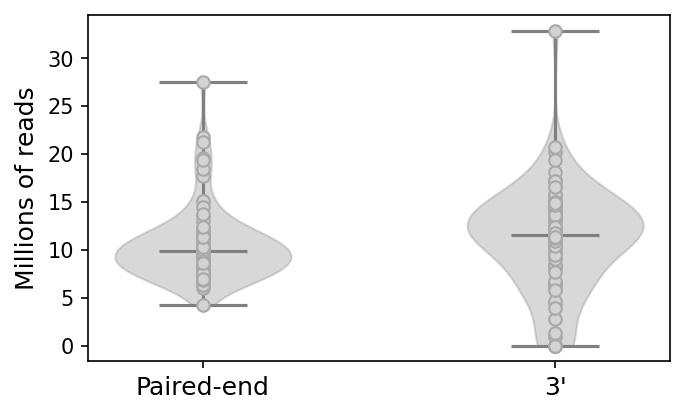

In [28]:
plt.figure(figsize=(5, 3), dpi=150)
vp = plt.violinplot([bgi_depth, mgi_depth],
                     showmedians=True)
for p in vp['bodies']:
    p.set_facecolor('grey')
    p.set_edgecolor('grey')
vp['cmedians'].set_edgecolor('grey')
vp['cmins'].set_edgecolor('grey')
vp['cmaxes'].set_edgecolor('grey')
vp['cbars'].set_edgecolor('grey')
plt.scatter(x=[1] * bgi_depth.shape[0], y=bgi_depth,
            edgecolor='darkgrey', facecolor='lightgrey',
            zorder=2)
plt.scatter(x=[2] * mgi_depth.shape[0], y=mgi_depth,
            edgecolor='darkgrey', facecolor='lightgrey',
            zorder=2)
plt.xticks([1, 2], ['Paired-end', "3'"], fontsize=12)
yl = plt.ylabel('Millions of reads', fontsize=12)

### **Number of genes detected**

In [29]:
ngenes = pd.concat([mgi_umi.astype(bool).sum(axis=0),
                    mgi_counts.astype(bool).sum(axis=0),
                    bgi_tpm.astype(bool).sum(axis=0)],
                    axis=1)
ngenes.columns = ["3' UMI\n(STAR)", "3' counts\n(featureCounts)", "Paired-end\n(RSEM)"]

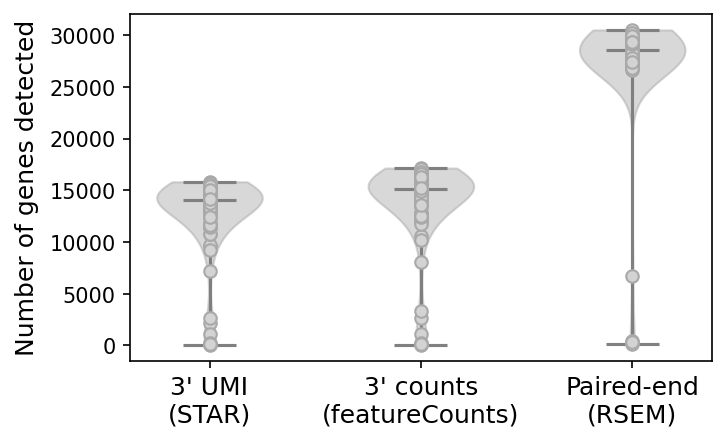

In [30]:
plt.figure(figsize=(5, 3), dpi=150)
vp = plt.violinplot(ngenes, showmedians=True)
for p in vp['bodies']:
    p.set_facecolor('grey')
    p.set_edgecolor('grey')
vp['cmedians'].set_edgecolor('grey')
vp['cmins'].set_edgecolor('grey')
vp['cmaxes'].set_edgecolor('grey')
vp['cbars'].set_edgecolor('grey')
for i in range(3):
    plt.scatter([i + 1] * ngenes.shape[0], ngenes.iloc[:, i],
                edgecolor='darkgrey', facecolor='lightgrey',
                zorder=2)
xt = plt.xticks(range(1, 4), ngenes.columns, fontsize=12)
xl = plt.ylabel('Number of genes detected', fontsize=12, labelpad=5)

Remove samples that aren't present in both datasets

### Number of genes detected versus sequencing depth
The gene numbers aren't entirely comparable because we used different genome annotations for mapping and quantification

In [31]:
mgi_multiqc = mgi_multiqc.set_index('sample_name')

In [32]:
bgi_reads = bgi_multiqc.groupby('sample')['total_reads'].sum()
bgi_mapped = bgi_multiqc.groupby('sample')['uniquely_mapped_percent'].mean()

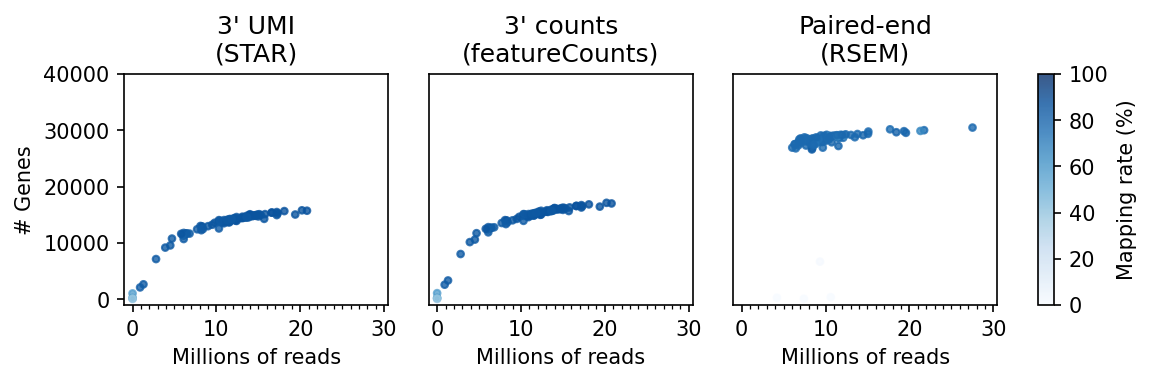

In [33]:
fig, axs = plt.subplots(1, 4, figsize=(8, 2), dpi=150,
                        width_ratios=[.325, .325, .325, .02])

for i in range(2):
    axs[i].scatter(x=mgi_multiqc.loc[ngenes.index, 'M Seqs'], y=ngenes.iloc[:, i],
                   c=mgi_multiqc.loc[ngenes.index, '% Aligned'].str.replace('%', '').astype(float).values,
                   s=10, alpha=.8, cmap='Blues',
                   vmin=0, vmax=100)
    axs[i].set_title(ngenes.columns[i])

bgi = axs[2].scatter(x=bgi_reads.loc[ngenes.index] / 1e6, y=ngenes.iloc[:, 2], c=bgi_mapped.loc[ngenes.index],
                     s=10, alpha=.8, cmap='Blues',
                     vmin=0, vmax=100)
axs[2].set_title(ngenes.columns[2])

for ax in axs[:3]:
    ax.set_xlabel('Millions of reads')
    ax.set_ylim(-1000, 40000)
    ax.set_yticks([])
    ax.set_xlim(-1, 30.5)
    ax.set_xticks(np.arange(0, 30, 1), minor=True)
axs[0].set_yticks([0, 10000, 20000, 30000, 40000])
yl = axs[0].set_ylabel('# Genes')

c = fig.colorbar(bgi, cax=axs[3], label='Mapping rate (%)')

### **How many genes are only detected by paired-end sequencing or 3' sequencing?**

In [34]:
mgi_genes = mgi_counts.loc[mgi_counts.astype(bool).any(axis=1), :].index.tolist()
bgi_genes = bgi_tpm.loc[bgi_tpm.astype(bool).any(axis=1), :].index.tolist()
only_bgi = [i for i in bgi_genes if not i in mgi_genes]
only_mgi = [i for i in mgi_genes if not i in bgi_genes]

In [35]:
gp = GProfiler(return_dataframe=True)
universe = list(set(mgi_genes).intersection(bgi_genes))

**The universe are all detected genes across both techniques in the annotation**

In [36]:
printmd(f"**Overall, {len(only_bgi)} genes are only identified with paired-end sequencing with an average expression of {round(np.mean(bgi_tpm.loc[only_bgi, :]), 1)} TPM.**")
enrichments = gp.profile(query=only_bgi, organism='drerio', background=universe)
enrichments = enrichments[enrichments['source'].str.contains('GO')]
if not enrichments.empty:
    printmd(f'**These genes are enriched for the following terms:**')
    for i in enrichments['name']:
        print(i)
else:
    printmd('**These genes are not enriched for specific terms.**')
print('\n')

for t, n in treatments.items():
    mgi_t_genes = mgi_counts[mgi_counts.filter(like=t).astype(bool).any(axis=1)].index
    bgi_t_genes = bgi_tpm[bgi_tpm.filter(like=t).astype(bool).any(axis=1)].index
    
    t_only_bgi = [i for i in bgi_t_genes if not i in mgi_t_genes]
    meantpm = round(np.mean(bgi_tpm.filter(like=t).loc[t_only_bgi]), 1)
    printmd(f'**For {n}, there are {len(t_only_bgi)} genes are only identified in paired-end sequencing with an average of {meantpm} TPMs**')

    enrichments = gp.profile(query=t_only_bgi, organism='drerio', background=universe)
    enrichments = enrichments[enrichments['source'].str.contains('GO')]
    if not enrichments.empty:
        printmd(f'**These genes are enriched for the following terms:**')
        for i in enrichments['name']:
            print(i)
        print('\n')
    else:
        print(f'These genes are not enriched for any specific terms.')    

**Overall, 7945 genes are only identified with paired-end sequencing with an average expression of 4.0 TPM.**

**These genes are enriched for the following terms:**

arylamine N-acetyltransferase activity
ubiquitin protein ligase activity
ubiquitin-like protein ligase activity
mRNA processing
acyltransferase activity




**For CdCl2 treatment, there are 11081 genes are only identified in paired-end sequencing with an average of 5.9 TPMs**

**These genes are enriched for the following terms:**

G protein-coupled receptor activity
G protein-coupled receptor signaling pathway
transmembrane signaling receptor activity
signaling receptor activity
molecular transducer activity
olfactory receptor activity
G protein-coupled peptide receptor activity
peptide receptor activity
neuropeptide receptor activity
immune response
odorant binding
detection of chemical stimulus involved in sensory perception of smell
detection of chemical stimulus involved in sensory perception
detection of chemical stimulus
sensory perception of smell
immune system process
sensory perception of chemical stimulus
membrane
signal transduction
detection of stimulus involved in sensory perception
response to stimulus
disruption of anatomical structure in another organism
extracellular region
cell-cell recognition




**For ethoprop treatment, there are 10737 genes are only identified in paired-end sequencing with an average of 4.5 TPMs**

**These genes are enriched for the following terms:**

G protein-coupled receptor activity
G protein-coupled receptor signaling pathway
transmembrane signaling receptor activity
signaling receptor activity
molecular transducer activity
olfactory receptor activity
detection of chemical stimulus involved in sensory perception of smell
odorant binding
detection of chemical stimulus involved in sensory perception
detection of chemical stimulus
sensory perception of smell
cell-cell recognition
RNA polymerase II transcription regulatory region sequence-specific DNA binding
sensory perception of chemical stimulus
detection of stimulus involved in sensory perception
transcription regulatory region nucleic acid binding
transcription cis-regulatory region binding
sequence-specific double-stranded DNA binding
immune response
cell recognition
acrosin binding
double-stranded DNA binding
wide pore channel activity




**For pirinixic acid treatment, there are 11415 genes are only identified in paired-end sequencing with an average of 4.9 TPMs**

**These genes are enriched for the following terms:**

G protein-coupled receptor activity
G protein-coupled receptor signaling pathway
transmembrane signaling receptor activity
molecular transducer activity
signaling receptor activity
olfactory receptor activity
immune response
odorant binding
detection of chemical stimulus involved in sensory perception of smell
detection of chemical stimulus involved in sensory perception
detection of chemical stimulus
sensory perception of smell
cytokine receptor binding
G protein-coupled peptide receptor activity
receptor ligand activity
signaling receptor activator activity
peptide receptor activity
signaling receptor regulator activity
transcription cis-regulatory region binding
transcription regulatory region nucleic acid binding
immune system process
sensory perception of chemical stimulus
RNA polymerase II transcription regulatory region sequence-specific DNA binding
detection of stimulus involved in sensory perception
sequence-specific double-stranded DNA binding
melanocortin receptor activity
n

**For DMSO treatment, there are 10514 genes are only identified in paired-end sequencing with an average of 4.4 TPMs**

**These genes are enriched for the following terms:**

G protein-coupled receptor activity
transmembrane signaling receptor activity
G protein-coupled receptor signaling pathway
signaling receptor activity
molecular transducer activity
olfactory receptor activity
detection of chemical stimulus involved in sensory perception of smell
odorant binding
detection of chemical stimulus involved in sensory perception
detection of chemical stimulus
sensory perception of smell
sensory perception of chemical stimulus
detection of stimulus involved in sensory perception
G protein-coupled peptide receptor activity
peptide receptor activity
detection of stimulus
signal transduction
arylamine N-acetyltransferase activity
cell communication
signaling
immune response
egg coat
external side of plasma membrane




**For NaAsO2 treatment, there are 11337 genes are only identified in paired-end sequencing with an average of 5.1 TPMs**

**These genes are enriched for the following terms:**

G protein-coupled receptor activity
G protein-coupled receptor signaling pathway
transmembrane signaling receptor activity
molecular transducer activity
signaling receptor activity
olfactory receptor activity
immune response
extracellular region
RNA polymerase II transcription regulatory region sequence-specific DNA binding
transcription cis-regulatory region binding
transcription regulatory region nucleic acid binding
sequence-specific double-stranded DNA binding
G protein-coupled peptide receptor activity
odorant binding
double-stranded DNA binding
immune system process
peptide receptor activity
neuropeptide receptor activity
positive regulation of ERK1 and ERK2 cascade
external side of plasma membrane




**For water control, there are 11867 genes are only identified in paired-end sequencing with an average of 6.2 TPMs**

**These genes are enriched for the following terms:**

G protein-coupled receptor activity
transmembrane signaling receptor activity
G protein-coupled receptor signaling pathway
molecular transducer activity
signaling receptor activity
G protein-coupled peptide receptor activity
olfactory receptor activity
transcription cis-regulatory region binding
transcription regulatory region nucleic acid binding
peptide receptor activity
membrane
RNA polymerase II transcription regulatory region sequence-specific DNA binding
sequence-specific double-stranded DNA binding
immune response
neuropeptide receptor activity
double-stranded DNA binding
potassium channel activity
melanocortin receptor activity
cytokine receptor binding
odorant binding
detection of chemical stimulus involved in sensory perception of smell
chemokine receptor activity
G protein-coupled chemoattractant receptor activity
detection of chemical stimulus involved in sensory perception
immune receptor activity
sequence-specific DNA binding
detection of stimulus involved in sensory perc

**For DMSO control, there are 12629 genes are only identified in paired-end sequencing with an average of 5.0 TPMs**

**These genes are enriched for the following terms:**

G protein-coupled receptor activity
transmembrane signaling receptor activity
molecular transducer activity
signaling receptor activity
G protein-coupled receptor signaling pathway
olfactory receptor activity
immune response
G protein-coupled peptide receptor activity
peptide receptor activity
odorant binding
signal transduction
membrane
detection of chemical stimulus involved in sensory perception of smell
immune response-regulating cell surface receptor signaling pathway
detection of chemical stimulus involved in sensory perception
signaling receptor binding
detection of chemical stimulus
sensory perception of smell
immune response-activating cell surface receptor signaling pathway
immune system process
RNA polymerase II transcription regulatory region sequence-specific DNA binding
receptor ligand activity
cell communication
signaling receptor activator activity
immune response-regulating signaling pathway
cytokine receptor binding
signaling
response to chemical
transcription regulat

**Most notably, these are generally GPCRs. We similarly saw taste receptors (also GPCRs) not being detected in _Drosophila_.**

In [37]:
printmd(f"**Overall, {len(only_mgi)} genes are only identified by 3' sequencing with an average expression of {round(np.mean(mgi_counts_permil.loc[only_mgi, :]), 1)} CPMs.**")
enrichments = gp.profile(query=only_mgi, organism='drerio', background=universe)
if not enrichments.empty:
    printmd(f'**These genes are enriched for the following terms:**')
    for i in enrichments['name']:
        print(i)
else:
    printmd('**These genes are not enriched for specific terms.**')
print('\n')

for t, n in treatments.items():
    mgi_t_genes = mgi_counts[mgi_counts.filter(like=t).astype(bool).any(axis=1)].index
    bgi_t_genes = bgi_tpm[bgi_tpm.filter(like=t).astype(bool).any(axis=1)].index
    
    t_only_mgi = [i for i in mgi_t_genes if not i in bgi_t_genes]
    meancpm = round(np.mean(mgi_counts_permil.filter(like=t).loc[t_only_mgi]), 1)
    printmd(f"**For {n}, there are {len(t_only_mgi)} genes are only identified in 3' sequencing with an average of {meancpm} CPMs**")

    enrichments = gp.profile(query=t_only_mgi, organism='drerio', background=universe)
    if not enrichments.empty:
        printmd(f'**These genes are enriched for the following terms:**')
        for i in enrichments['name']:
            print(i)
        print('\n')
    else:
        print(f'These genes are not enriched for any specific terms.')    

**Overall, 994 genes are only identified by 3' sequencing with an average expression of 1.2 CPMs.**

**These genes are not enriched for specific terms.**

**For CdCl2 treatment, there are 638 genes are only identified in 3' sequencing with an average of 4.5 CPMs**

**These genes are enriched for the following terms:**

olfactory receptor activity
protein kinase activity




**For ethoprop treatment, there are 572 genes are only identified in 3' sequencing with an average of 2.6 CPMs**

**These genes are enriched for the following terms:**

olfactory receptor activity
G protein-coupled receptor activity
carbohydrate binding




**For pirinixic acid treatment, there are 598 genes are only identified in 3' sequencing with an average of 2.2 CPMs**

**These genes are enriched for the following terms:**

G protein-coupled receptor activity
signaling receptor activity
molecular transducer activity
olfactory receptor activity
transmembrane signaling receptor activity
G protein-coupled receptor signaling pathway




**For DMSO treatment, there are 666 genes are only identified in 3' sequencing with an average of 2.4 CPMs**

These genes are not enriched for any specific terms.


**For NaAsO2 treatment, there are 519 genes are only identified in 3' sequencing with an average of 2.3 CPMs**

**These genes are enriched for the following terms:**

immune response




**For water control, there are 542 genes are only identified in 3' sequencing with an average of 3.0 CPMs**

**These genes are enriched for the following terms:**

G protein-coupled receptor activity
olfactory receptor activity
G protein-coupled receptor signaling pathway
transmembrane signaling receptor activity
signaling receptor activity
molecular transducer activity
Cytokine-cytokine receptor interaction




**For DMSO control, there are 418 genes are only identified in 3' sequencing with an average of 3.2 CPMs**

These genes are not enriched for any specific terms.


**However, for 3', too, we see many GPCR-related terms popping up. Could there be some duplication in the annotation of these GPCRs in _Danio_?**

### **Mantel test**
The Mantel test is a statistical test of the correlation between two matrices.

In [38]:
log_bgi_tpm = np.log(bgi_tpm + 1)
log_mgi_counts_permil = np.log(mgi_counts_permil + 1)

In [39]:
bgi_cor = pdist(np.corrcoef(log_bgi_tpm.T))
mgi_cor = pdist(np.corrcoef(log_mgi_counts_permil.T))

In [40]:
bgi_mgi_mantel = mantel.test(bgi_cor, mgi_cor, perms=bgi_cor.shape[0],
                             method='pearson', tail='upper')
print("The mantel test between the Paired-end TPMs and the 3' counts per million gives the following correlation, p-value, and Z-score")
bgi_mgi_mantel

The mantel test between the Paired-end TPMs and the 3' counts per million gives the following correlation, p-value, and Z-score


MantelResult(0.1533991535756454, 0.13488098736409052, 1.4933178003426553)

**There are no significant differences between the sample correlations from MGI and BGI data and they are correlated**

### **Sample correlations within and between techniques**

In [41]:
sortedcols = log_bgi_tpm.columns.tolist()
sortedcols.sort()
log_bgi_tpm = log_bgi_tpm[sortedcols]
log_mgi_counts_permil = log_mgi_counts_permil[sortedcols]

In [42]:
combined_counts = pd.merge(left=log_bgi_tpm, right=log_mgi_counts_permil,
                           left_index=True, right_index=True,
                           suffixes=['_Paired-end', "_3'"])
combined_counts_cor = combined_counts.corr()

In [43]:
drugcmap = {k: v for v, k in enumerate(np.unique(combined_counts_cor.columns.str[3:6]))}
drugorder = np.array([drugcmap[i[3:6]] for i in combined_counts_cor.columns])
drugcmaprev = {v: k for k, v in drugcmap.items()}

In [44]:
tpcmap = {k: v for v, k in enumerate(np.unique(combined_counts_cor.columns.str[7]))}
tporder = np.array([tpcmap[i[7]] for i in combined_counts_cor.columns])
tpcmaprev = {v: k for k, v in tpcmap.items()}

In [45]:
drugcmap

{'000': 0, '001': 1, '002': 2, '003': 3, '004': 4, '006': 5, '999': 6}

#### **Inter- and intra-technology correlations**

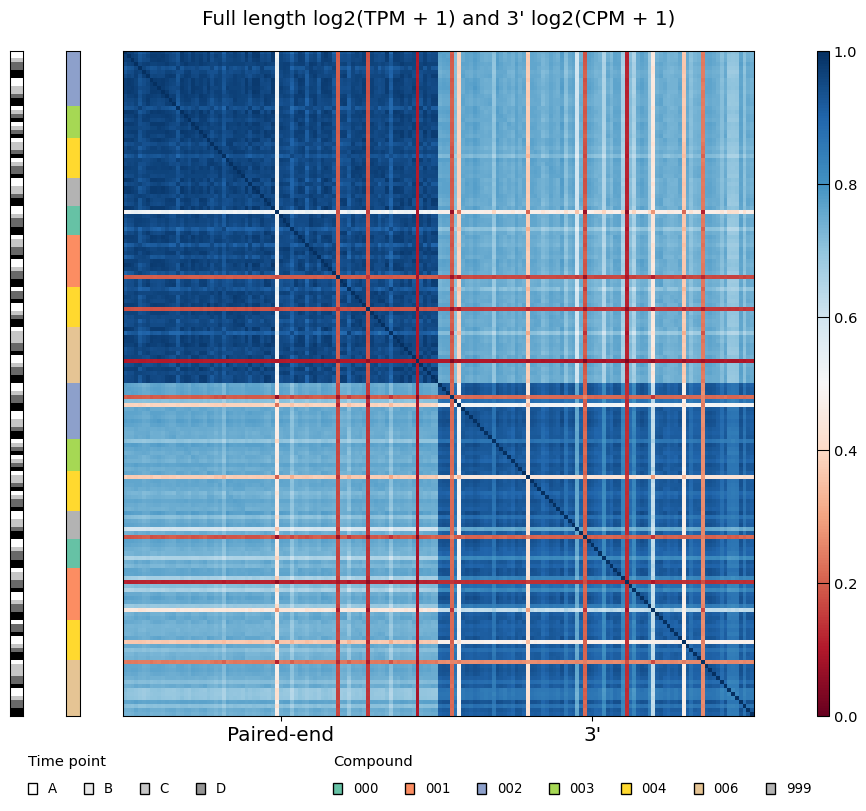

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(10, 9),
                        width_ratios=[.02, .02, .96],
                        dpi=96)
plt.title("Full length log2(TPM + 1) and 3' log2(CPM + 1)",
          fontsize=15, pad=20)
c_im = axs[1].imshow(drugorder.reshape(1,-1).T,
                     cmap='Set2')
axs[1].set_aspect('auto')
for ax in axs:
    ax.set_yticks([])
    ax.set_xticks([])
t_im = axs[0].imshow(tporder.reshape(1,-1).T,
                     cmap='Greys')
axs[0].set_aspect('auto')
for ax in axs:
    ax.set_yticks([])
    ax.set_xticks([])

# cluster legend
colors = [c_im.cmap(c_im.norm(c)) for c in range(7)]
patches = [mpatches.Patch(facecolor=colors[i],
                          label=drugcmaprev[i],
                          edgecolor='black')
           for i in range(7)]
leg = plt.legend(handles=patches, handlelength=.7, handleheight=.8,
                 bbox_to_anchor=(1.1, -.05),
                 loc=1, borderaxespad=0., fontsize=10,
                 ncols=7, alignment='left',
                 title='Compound', title_fontproperties={'size': 11},
                 labelspacing=1)
leg.get_frame().set_edgecolor('white')

# tp legend
colors = [t_im.cmap(c_im.norm(c)) for c in range(4)]
patches = [mpatches.Patch(facecolor=colors[i],
                          label=tpcmaprev[i],
                          edgecolor='black')
           for i in range(4)]
leg = axs[0].legend(handles=patches, handlelength=.7, handleheight=.8,
                 bbox_to_anchor=(1., -.05),
                 loc=2, borderaxespad=0., fontsize=10,
                 ncols=5, alignment='left',
                 title='Time point', title_fontproperties={'size': 11},
                 labelspacing=1)
leg.get_frame().set_edgecolor('white')

corim = axs[2].imshow(combined_counts_cor, cmap='RdBu',
                      vmin=.0, vmax=1)
quart = int(combined_counts_cor.shape[0] / 4)
axs[2].set_xticks([quart, quart * 3], [combined_counts_cor.index[quart].split('_')[1], combined_counts_cor.index[quart * 3].split('_')[1]],
                  fontsize=15)
axs[2].set_aspect('auto')

cax = axs[2].inset_axes([1.1, 0, 0.02, 1])
cbar = plt.colorbar(corim, ax=axs[2], cax=cax)
cbar.ax.tick_params(axis='y', direction='in',
                    length=9)
cbar.ax.tick_params(labelsize=11)

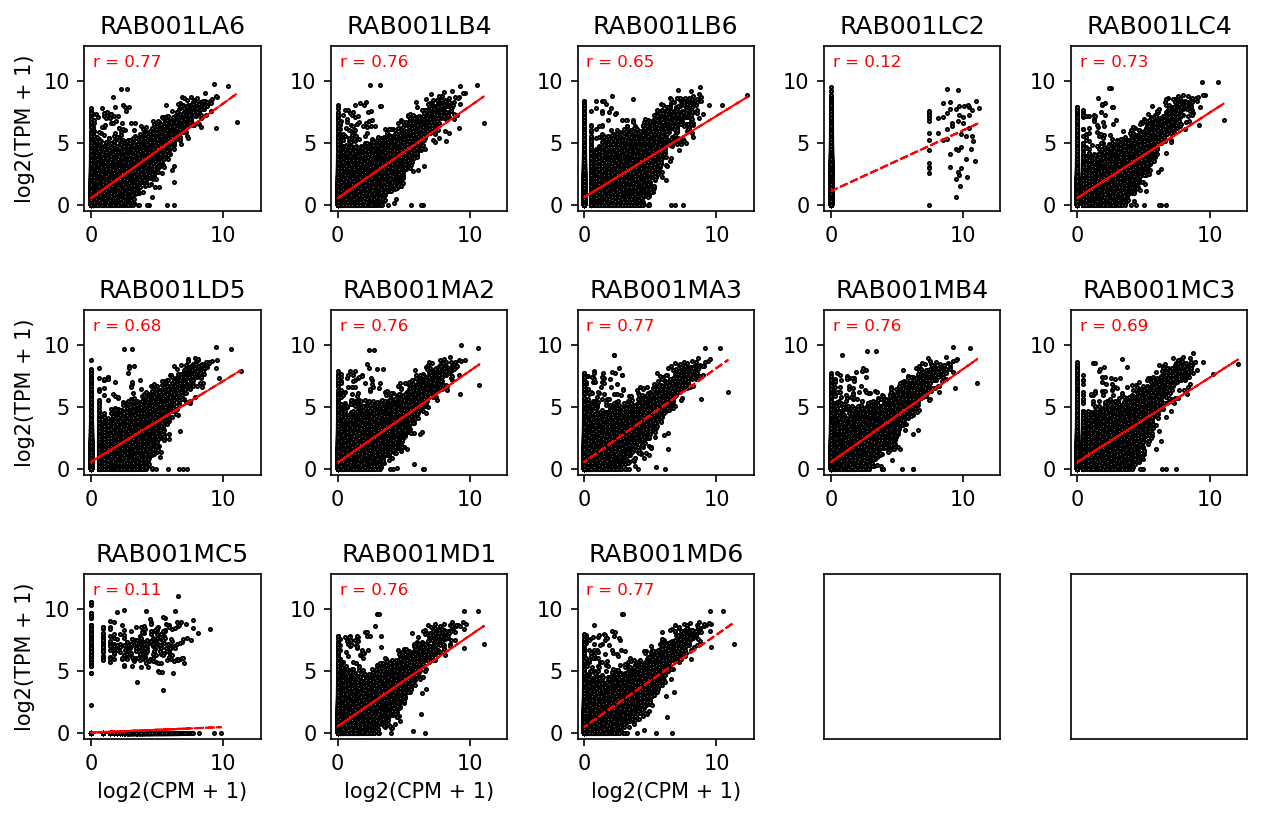

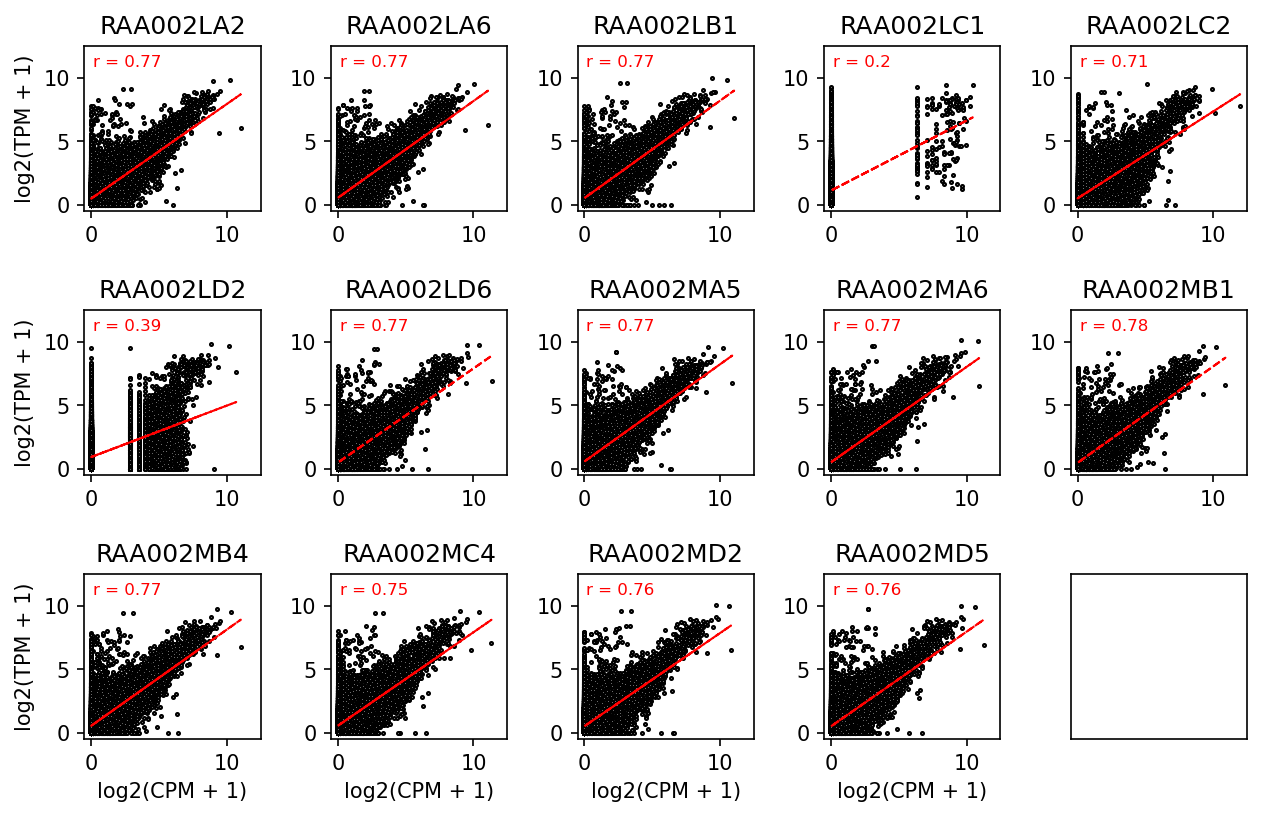

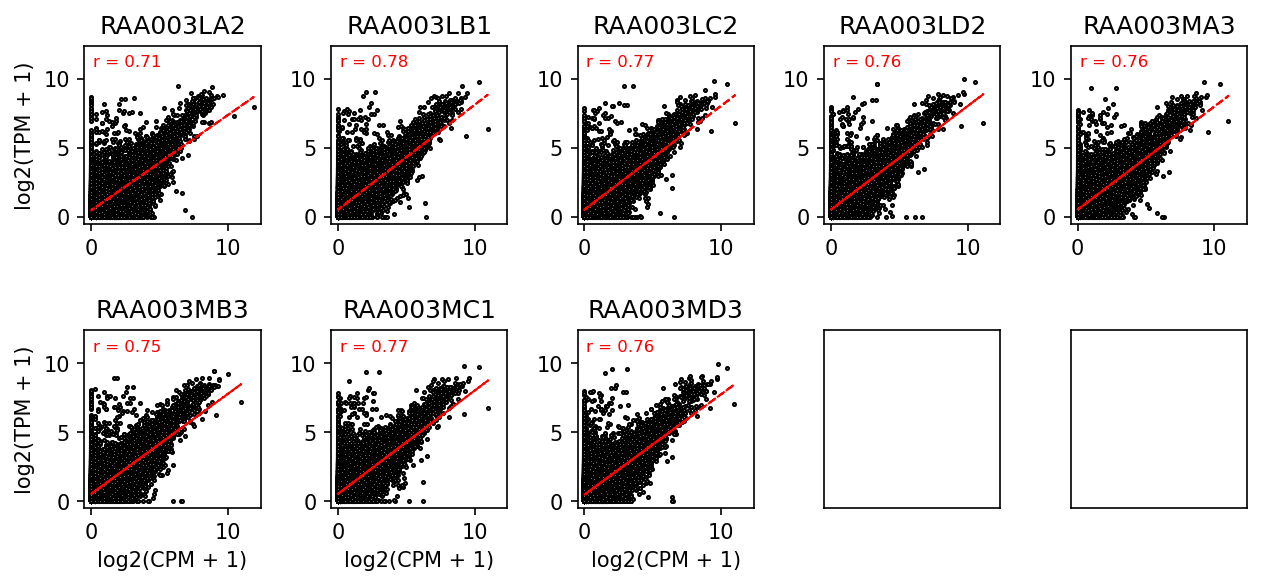

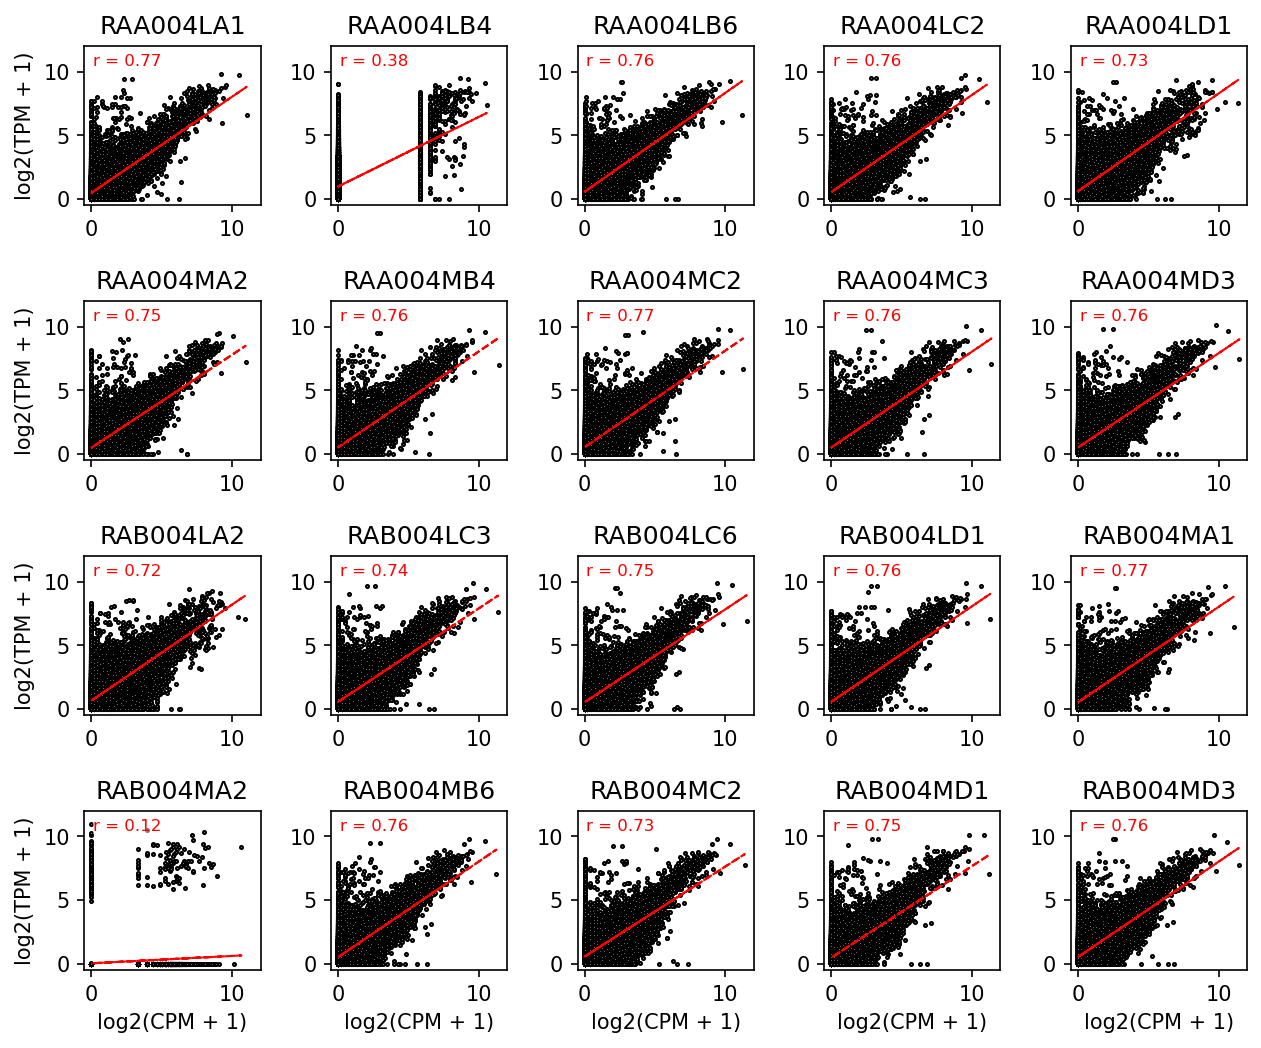

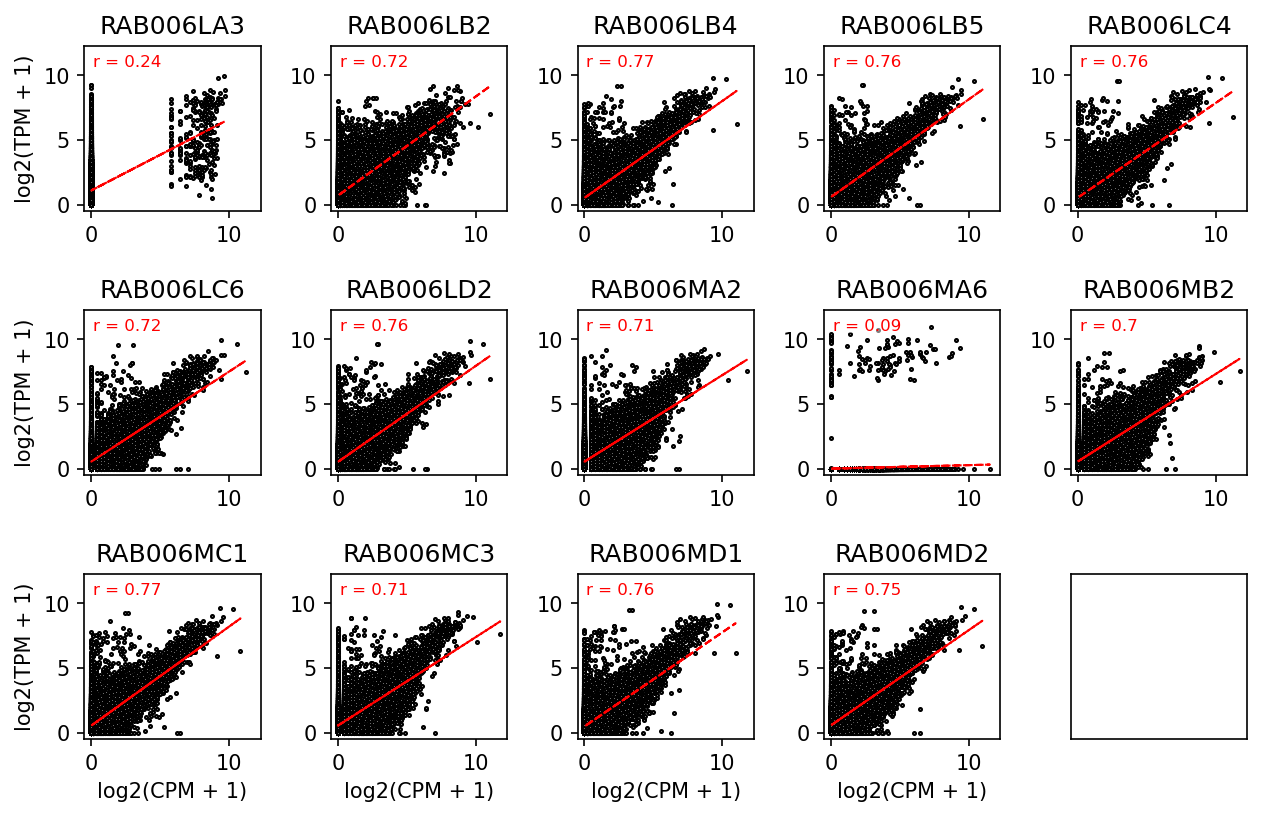

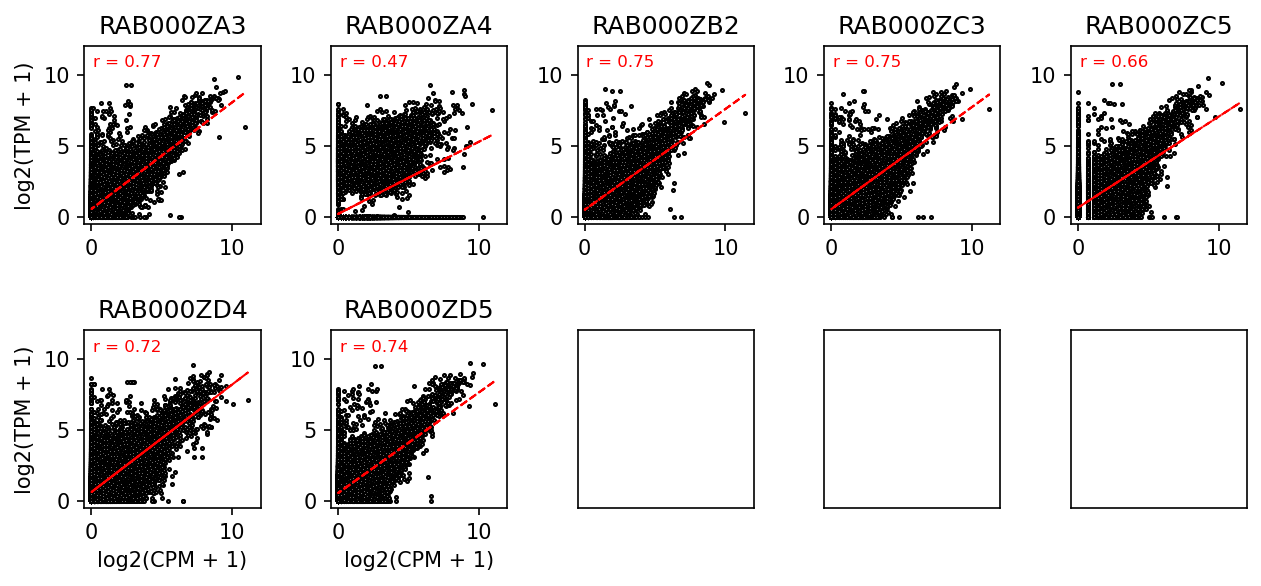

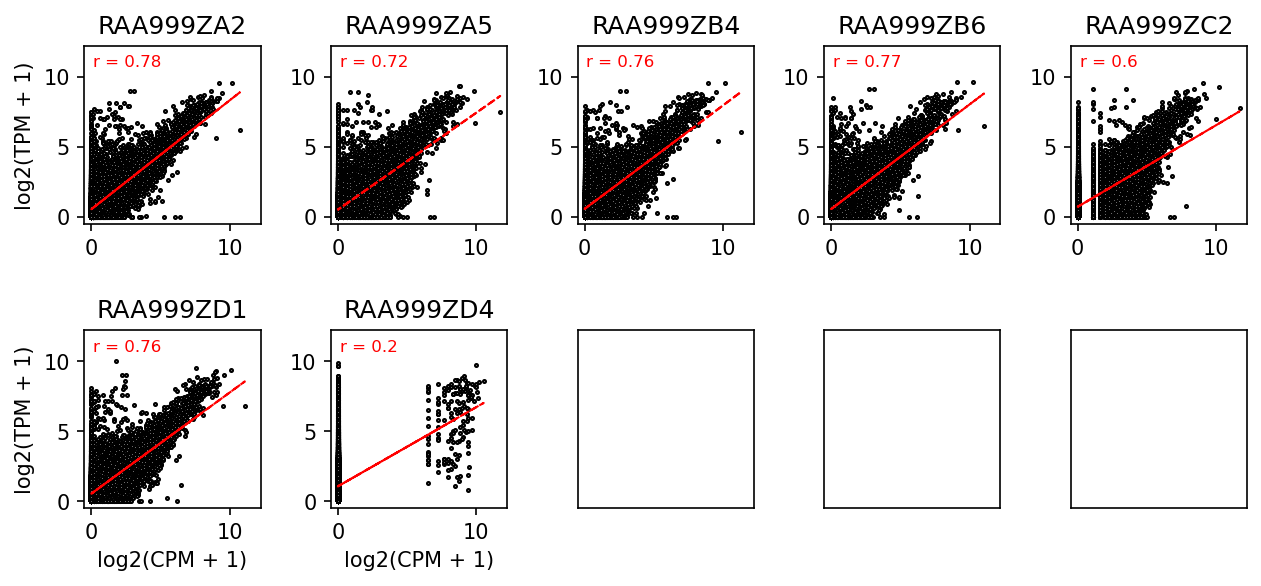

In [47]:
#### **Sample-specific correlations between 3' and paired-end sequencing**

lowcor = []
for t in treatments:
    mgi = log_mgi_counts_permil.filter(like=t)
    bgi = log_bgi_tpm.filter(like=t)
    genes = [i for i in mgi.index if i in bgi.index]  # one gene missing in BGI
    sortedcols = mgi.columns.tolist()
    sortedcols.sort()
    mgi = mgi.loc[genes, sortedcols]
    bgi = bgi.loc[genes, sortedcols]
    
    ncols = 5
    nrows = ceil(bgi.shape[1] / ncols)
    if nrows > 1:
        figsize = (10, 2 * nrows)
    else:
        figsize = (10, 1.5)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize,
                            dpi=150)
    plt.subplots_adjust(hspace=.6, wspace=.4)
    for c, ax in zip(mgi.columns, axs.ravel()):
        ax.scatter(x=mgi.loc[:, c], y=bgi.loc[:, c],
                   s=2, facecolors='white', edgecolors='black')
        ax.set_title(c)
        a, b = np.polynomial.polynomial.polyfit(mgi.loc[:, c], bgi.loc[:, c], 1)
        x, y = mgi.loc[:, c], a + b * mgi.loc[:, c]
        ax.plot(x, y, ls='--', lw=1, color='red')
        cor = round(np.corrcoef(mgi.loc[:, c], bgi.loc[:, c])[0, 1], 2)
        if cor < .65:
            lowcor.append(c)
        t = ax.text(.05, .95, f'r = {cor}',
                    fontsize=8, color='red', ha='left', va='top',
                    transform=ax.transAxes)
        t.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0, pad=0))
        maxlim = np.max([mgi.max(), bgi.max()])
        ax.set_xlim(-.5, maxlim + .5)
        ax.set_ylim(-.5, maxlim + .5)
    if not nrows == 1:
        for i in range(ncols):
             axs[nrows - 1][i].set_xlabel('log2(CPM + 1)', fontsize=10)
        for i in range(nrows):
            axs[i][0].set_ylabel('log2(TPM + 1)', fontsize=10)
    else:
        for i in range(ncols):
            axs[i].set_xlabel('log2(CPM + 1)', fontsize=10)
        axs[0].set_ylabel('log2(TPM + 1)', fontsize=10)
    nopen = len(axs.ravel()) - mgi.shape[1]
    for i in range(nopen):
        axs[nrows - 1][ncols - i - 1].set_xticks([])
        axs[nrows - 1][ncols - i - 1].set_yticks([])
        axs[nrows - 1][ncols - i - 1].set_xlabel('')
    plt.show()
    print('\n\n')
del mgi, bgi

In [48]:
mgi_multiqc = mgi_multiqc.reset_index()
lowcor_qc_mgi = mgi_multiqc[mgi_multiqc['sample_name'].isin(lowcor)][['sample_name', 'M Seqs', '% Aligned']]
lowcor_qc_mgi['M Seqs'] = lowcor_qc_mgi['M Seqs']
lowcor_qc_mgi = lowcor_qc_mgi.rename(columns={'M Seqs': 'million_reads', '% Aligned': 'uniquely_mapped_percent'})
lowcor_qc_mgi = lowcor_qc_mgi.set_index('sample_name')
lowcor_qc_bgi_reads = bgi_multiqc[bgi_multiqc['sample'].isin(lowcor)].groupby('sample')[['total_reads']].sum()
lowcor_qc_bgi_mapping_rate = bgi_multiqc[bgi_multiqc['sample'].isin(lowcor)].groupby('sample')[['uniquely_mapped_percent']].mean()
lowcor_qc_bgi = pd.concat([lowcor_qc_bgi_reads, lowcor_qc_bgi_mapping_rate], axis=1)
lowcor_qc_bgi['total_reads'] = lowcor_qc_bgi['total_reads'] / 1e6
lowcor_qc_bgi = lowcor_qc_bgi.rename(columns={'total_reads': 'million_reads'})
pd.merge(left=lowcor_qc_mgi, right=lowcor_qc_bgi,
         left_index=True, right_index=True,
         suffixes=('_MGI', '_BGI'))

million_reads_MGI uniquely_mapped_percent_MGI  million_reads_BGI  \
sample_name                                                                     
RAA002LC1                  0.0                       39.9%          10.547068   
RAA002LD2                  1.3                       83.2%           6.866478   
RAA004LB4                  0.0                       56.2%           9.600704   
RAA999ZC2                  2.8                       83.1%          11.532857   
RAA999ZD4                  0.0                       38.9%           8.871288   
RAB000ZA4                 12.2                       85.2%           9.334713   
RAB001LC2                  0.0                       24.3%          11.034413   
RAB001MC5                 32.9                       84.3%          10.619621   
RAB004MA2                  0.9                       82.7%           4.205044   
RAB006LA3                  0.0                       59.1%           7.914682   
RAB006MA6                  4.7                       83.7%           7.417534   

             uniquely_mapped_percent_BGI  
sample_name                               
RAA002LC1                      78.271667  
RAA002LD2                      78.030000  
RAA004LB4                      78.636667  
RAA999ZC2                      79.413333  
RAA999ZD4                      78.421667  
RAB000ZA4                       1.358333  
RAB001LC2                      79.746667  
RAB001MC5                       0.013333  
RAB004MA2                       0.050000  
RAB006LA3                      77.270000  
RAB006MA6                       0.008333

**These are poor quality samples for at least one technique.**

In [49]:
remove_samples = lowcor

In [50]:
log_mgi_counts_permil_filtered = log_mgi_counts_permil.drop(remove_samples, axis=1)
log_bgi_tpm_filtered = log_bgi_tpm.drop(remove_samples, axis=1)

In [51]:
assert log_bgi_tpm_filtered.shape[1] == log_mgi_counts_permil_filtered.shape[1]

In [52]:
combined_counts_f = pd.merge(left=log_bgi_tpm_filtered, right=log_mgi_counts_permil_filtered,
                             left_index=True, right_index=True,
                             suffixes=['_Paired-end', "_3'"])
combined_counts_cor_f = combined_counts_f.corr()

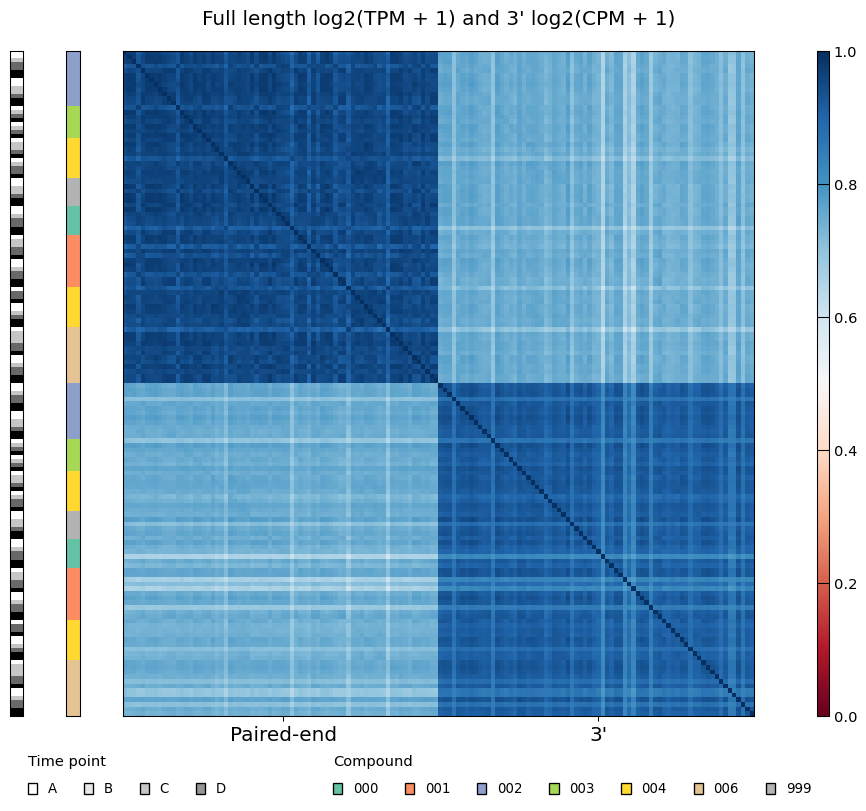

In [53]:
fig, axs = plt.subplots(1, 3, figsize=(10, 9),
                        width_ratios=[.02, .02, .96],
                        dpi=96)
plt.title("Full length log2(TPM + 1) and 3' log2(CPM + 1)",
          fontsize=15, pad=20)
c_im = axs[1].imshow(drugorder.reshape(1,-1).T,
                     cmap='Set2')
axs[1].set_aspect('auto')
for ax in axs:
    ax.set_yticks([])
    ax.set_xticks([])
t_im = axs[0].imshow(tporder.reshape(1,-1).T,
                     cmap='Greys')
axs[0].set_aspect('auto')
for ax in axs:
    ax.set_yticks([])
    ax.set_xticks([])

# cluster legend
colors = [c_im.cmap(c_im.norm(c)) for c in range(7)]
patches = [mpatches.Patch(facecolor=colors[i],
                          label=drugcmaprev[i],
                          edgecolor='black')
           for i in range(7)]
leg = plt.legend(handles=patches, handlelength=.7, handleheight=.8,
                 bbox_to_anchor=(1.1, -.05),
                 loc=1, borderaxespad=0., fontsize=10,
                 ncols=7, alignment='left',
                 title='Compound', title_fontproperties={'size': 11},
                 labelspacing=1)
leg.get_frame().set_edgecolor('white')

# tp legend
colors = [t_im.cmap(c_im.norm(c)) for c in range(4)]
patches = [mpatches.Patch(facecolor=colors[i],
                          label=tpcmaprev[i],
                          edgecolor='black')
           for i in range(4)]
leg = axs[0].legend(handles=patches, handlelength=.7, handleheight=.8,
                 bbox_to_anchor=(1., -.05),
                 loc=2, borderaxespad=0., fontsize=10,
                 ncols=5, alignment='left',
                 title='Time point', title_fontproperties={'size': 11},
                 labelspacing=1)
leg.get_frame().set_edgecolor('white')

corim = axs[2].imshow(combined_counts_cor_f, cmap='RdBu',
                      vmin=.0, vmax=1)
quart = int(combined_counts_cor_f.shape[0] / 4)
axs[2].set_xticks([quart, quart * 3], [combined_counts_cor_f.index[quart].split('_')[1], combined_counts_cor_f.index[quart * 3].split('_')[1]],
                  fontsize=15)
axs[2].set_aspect('auto')

cax = axs[2].inset_axes([1.1, 0, 0.02, 1])
cbar = plt.colorbar(corim, ax=axs[2], cax=cax)
cbar.ax.tick_params(axis='y', direction='in',
                    length=9)
cbar.ax.tick_params(labelsize=11)

### **Compare the log2FC between treatment and control across technologies**

In [54]:
tps = ['A', 'B', 'C', 'D', 'E']
doses = ['L', 'M']
controls = {
    '001': '000',
    '002': '999',
    '003': '999',
    '004': '999',
    '006': '000'
}

In [55]:
bgi_log2fcs = {}
mgi_log2fcs = {}
for t, n in treatments.items():
    if not t in ['000', '999']:
        for tp in tps:
            for d in doses:
                if t != '003':
                    t_idxs = [i for i in log_bgi_tpm_filtered.columns if (i[3:6] == t) and (i[6] == d) and (i[7] == tp)]
                else:
                    t_idxs = [i for i in log_bgi_tpm_filtered.columns if (i[3:6] == t) and (i[6] == 'H') and (i[7] == tp)]
                c_idxs = [i for i in log_bgi_tpm_filtered.columns if (i[3:6] == controls[t]) and (i[7] == tp)]
                if (len(c_idxs) > 0) & (len(t_idxs) > 0):
                    genes = list(set(log_bgi_tpm_filtered.index).intersection(log_mgi_counts_permil_filtered.index))
                    bgi_treat = log_bgi_tpm_filtered.loc[genes, t_idxs].mean(axis=1)
                    bgi_cont = log_bgi_tpm_filtered.loc[genes, c_idxs].mean(axis=1)
                    bgi_log2fc = (bgi_treat - bgi_cont).sort_values(ascending=False)
                    bgi_log2fc.name = 'log2FC_BGI'
                    bgi_log2fcs[f'{t}{d}{tp}'] = bgi_log2fc
                    mgi_treat = log_mgi_counts_permil_filtered.loc[genes, t_idxs].mean(axis=1)
                    mgi_cont = log_mgi_counts_permil_filtered.loc[genes, c_idxs].mean(axis=1)
                    mgi_log2fc = (mgi_treat - mgi_cont).sort_values(ascending=False)
                    mgi_log2fc.name = 'log2FC_MGI'
                    mgi_log2fcs[f'{t}{d}{tp}'] = mgi_log2fc
                else:
                    print(f'No results for treatment {t} at time point {tp} at dose {d}')

No results for treatment 001 at time point E at dose L
No results for treatment 001 at time point E at dose M
No results for treatment 002 at time point C at dose L
No results for treatment 002 at time point C at dose M
No results for treatment 002 at time point E at dose L
No results for treatment 002 at time point E at dose M
No results for treatment 003 at time point A at dose L
No results for treatment 003 at time point A at dose M
No results for treatment 003 at time point B at dose L
No results for treatment 003 at time point B at dose M
No results for treatment 003 at time point C at dose L
No results for treatment 003 at time point C at dose M
No results for treatment 003 at time point D at dose L
No results for treatment 003 at time point D at dose M
No results for treatment 003 at time point E at dose L
No results for treatment 003 at time point E at dose M
No results for treatment 004 at time point C at dose L
No results for treatment 004 at time point C at dose M
No results

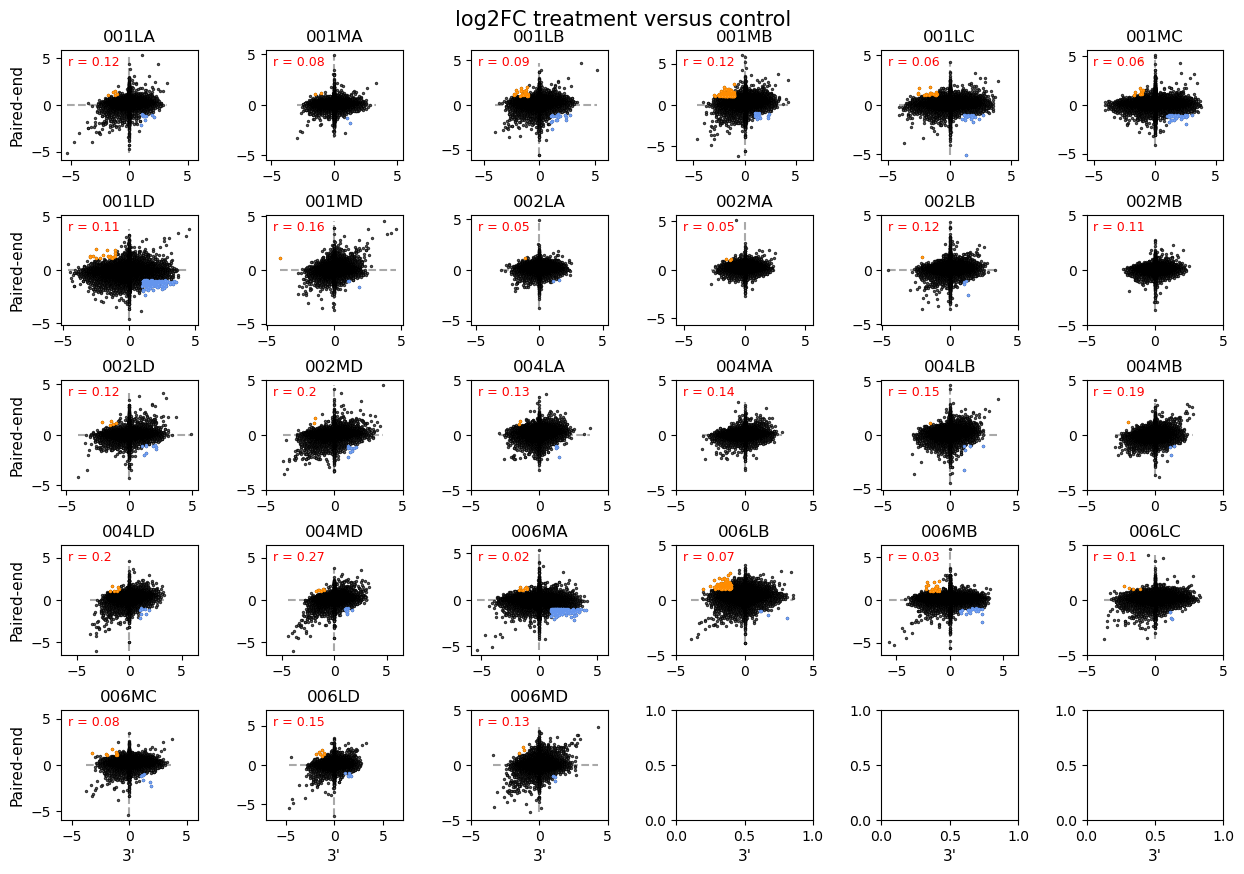

In [56]:
ncols = 6
nrows = ceil(len(bgi_log2fcs.keys()) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 2 * nrows))
fig.subplots_adjust(hspace=.5, wspace=.5)
for k, ax in zip(bgi_log2fcs.keys(), axs.ravel()):
    bgi = bgi_log2fcs[k]
    mgi = mgi_log2fcs[k]
    merged = pd.DataFrame(bgi).merge(pd.DataFrame(mgi), left_index=True, right_index=True)
    merged = merged[['log2FC_BGI', 'log2FC_MGI']]
    x = merged['log2FC_MGI']
    y = merged['log2FC_BGI']
    blue = np.logical_and(x > 1, y < -1)
    orange = np.logical_and(y > 1, x < -1)
    ax.scatter(x=x, y=y,
               s=2, facecolor='white', edgecolor='black', alpha=.8)
    ax.scatter(x=x[blue], y=y[blue],
               s=2, facecolor='white', edgecolor='cornflowerblue')
    ax.scatter(x=x[orange], y=y[orange],
               s=2, facecolor='white', edgecolor='darkorange')
    r = np.corrcoef(x, y)[0, 1]
    t = ax.text(.05, .95, f'r = {round(r, 2)}',
                color='red', fontsize=9, ha='left', va='top',
                transform=ax.transAxes)
    t.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0, pad=0))
    ax.set_title(k)
    ax.hlines(0, np.min(x), np.max(x), color='darkgrey', ls='--', zorder=-1)
    ax.vlines(0, np.min(y), np.max(y), color='darkgrey', ls='--', zorder=-1)
    maxlim = np.max([np.max(merged), np.abs(np.min(merged))])
    ax.set_xlim(-maxlim - .5, maxlim + .5)
    ax.set_ylim(-maxlim - .5, maxlim + .5)
    ax.set_xticks([-5, 0, 5])
    ax.set_yticks([-5, 0, 5])
for i in range(ncols):
    axs[nrows - 1][i].set_xlabel("3'", fontsize=11)
for i in range(nrows):
    axs[i][0].set_ylabel('Paired-end', fontsize=11)
plt.suptitle('log2FC treatment versus control', y=.92, fontsize=15)
plt.show()
del mgi, bgi

In [57]:
# for k, ax in zip(bgi_log2fcs.keys(), axs.ravel()):
#     bgi = bgi_log2fcs[k]
#     mgi = mgi_log2fcs[k]
#     merged = pd.DataFrame(bgi).merge(pd.DataFrame(mgi), left_index=True, right_index=True)
#     merged = merged[['log2FC_BGI', 'log2FC_MGI']]
#     print(merged.sort_values(by='log2FC_BGI'))
#     print(merged.sort_values(by='log2FC_MGI'))

Blue: a log2FC higher than 1 for paired-end data but a log2FC lower than -1 for 3' data <br>
Orange: a log2FC higher than 1 for 3' data but a log2FC lower than -1 for paired-end data

### **Compare technologies in PCA space**

In [58]:
colors = {
    '001': '#cc6677',
    '004': '#ddcc77',
    '002': '#117733',
    '003': '#44aa99',
    '006': '#882255',
    '000': '#c2ced1',
    '999': '#d1cdc2'
}

In [59]:
bgi = log_bgi_tpm_filtered.loc[log_bgi_tpm_filtered.astype(bool).any(axis=1), :]
bgi.columns = [f'{i}_BGI' for i in bgi.columns]
mgi = log_mgi_counts_permil_filtered.loc[log_mgi_counts_permil_filtered.astype(bool).any(axis=1), :]
mgi.columns = [f'{i}_MGI' for i in mgi.columns]

#### **Combined PCA embedding**

In [60]:
mgi_multiqc = mgi_multiqc.set_index('sample_name')

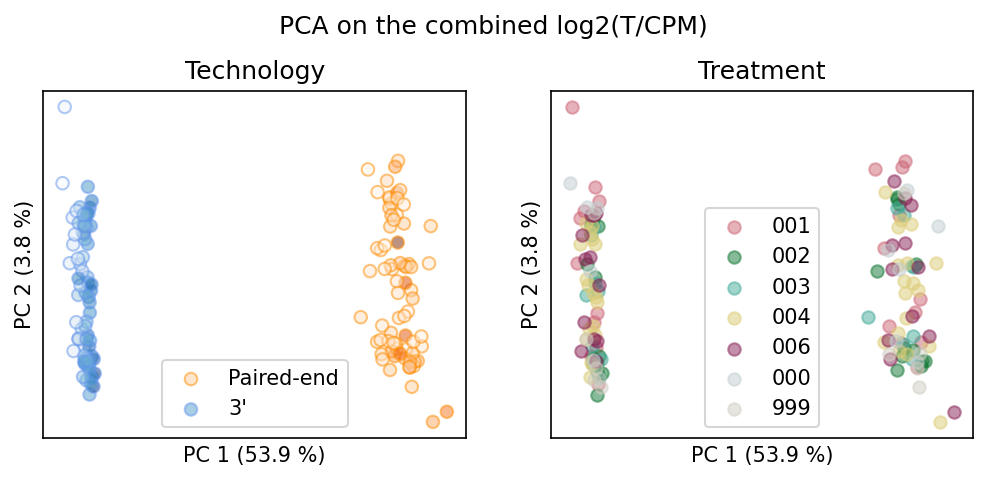

In [61]:
bgimgi = pd.merge(left=bgi, right=mgi, left_index=True, right_index=True)

ns_pca = PCA(n_components=2).fit(bgimgi.T)
varexp = ns_pca.explained_variance_ratio_
ns_pca = ns_pca.transform(bgimgi.T)
ns_pca = pd.DataFrame(ns_pca, index=bgimgi.columns, columns=['PC1', 'PC2'])

fig, axs = plt.subplots(1, 2, figsize=(8, 3),
                        dpi=150)

# plot coloured by technology
axs[0].scatter(x=ns_pca.filter(like='BGI', axis=0)['PC1'],
               y=ns_pca.filter(like='BGI', axis=0)['PC2'],
               edgecolor='darkorange', label='Paired-end',
               c=bgi_reads.loc[[i.replace('_BGI','') for i in ns_pca.filter(like='BGI', axis=0).index]].values,
               cmap='Oranges', alpha=.5)
axs[0].scatter(x=ns_pca.filter(like='MGI', axis=0)['PC1'],
               y=ns_pca.filter(like='MGI', axis=0)['PC2'],
               edgecolor='cornflowerblue', label="3'",
               c=mgi_multiqc.loc[[i.replace('_MGI','') for i in ns_pca.filter(like='MGI', axis=0).index], 'M Seqs'].values * 1e6,
               cmap='Blues', alpha=.5)
axs[0].legend()
axs[0].set_title('Technology')

# plot coloured by treatments
for t in treatments.keys():
    idx = [i for i in ns_pca.index if t in i]
    axs[1].scatter(ns_pca.loc[idx, 'PC1'], ns_pca.loc[idx, 'PC2'],
                   edgecolor=colors[t], facecolor=colors[t],
                   label=t, alpha=.5)
    axs[1].legend()
    axs[1].set_title('Treatment')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(f'PC 1 ({round(varexp[0] * 100, 1)} %)')
    ax.set_ylabel(f'PC 2 ({round(varexp[1] * 100, 1)} %)')
t = fig.suptitle('PCA on the combined log2(T/CPM)', y=1.05)

#### **Technique-specific PCA embedding**

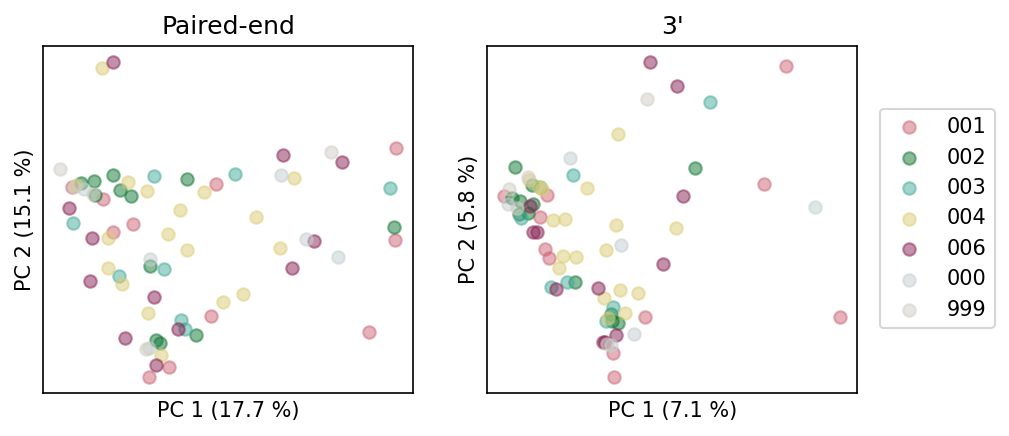

In [62]:
bgi_pca = PCA(n_components=2).fit(bgi.T)
bgi_varexp = bgi_pca.explained_variance_ratio_
bgi_pca = bgi_pca.transform(bgi.T)
bgi_pca = pd.DataFrame(bgi_pca, index=bgi.columns, columns=['PC1', 'PC2'])
mgi_pca = PCA(n_components=2).fit(mgi.T)
mgi_varexp = mgi_pca.explained_variance_ratio_
mgi_pca = mgi_pca.transform(mgi.T)
mgi_pca = pd.DataFrame(mgi_pca, index=mgi.columns, columns=['PC1', 'PC2'])

fig, axs = plt.subplots(1, 2, figsize=(7, 3),
                        dpi=150)
for t in treatments.keys():
    idx = [i for i in bgi_pca.index if t in i]
    axs[0].scatter(bgi_pca.loc[idx, 'PC1'], bgi_pca.loc[idx, 'PC2'],
                   edgecolor=colors[t], facecolor=colors[t],
                   label=t, alpha=.5)
    axs[0].set_title('Paired-end')
    axs[0].set_xlabel(f'PC 1 ({round(bgi_varexp[0] * 100, 1)} %)')
    axs[0].set_ylabel(f'PC 2 ({round(bgi_varexp[1] * 100, 1)} %)')
    idx = [i for i in mgi_pca.index if t in i]
    axs[1].scatter(mgi_pca.loc[idx, 'PC1'], mgi_pca.loc[idx, 'PC2'],
                   edgecolor=colors[t], facecolor=colors[t],
                   label=t, alpha=.5)
    axs[1].set_title("3'")
    axs[1].set_title("3'")
    axs[1].set_xlabel(f'PC 1 ({round(mgi_varexp[0] * 100, 1)} %)')
    axs[1].set_ylabel(f'PC 2 ({round(mgi_varexp[1] * 100, 1)} %)')
    axs[1].legend(bbox_to_anchor=(1.4, .85))
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [63]:
controls = {
    '001': '000',
    '002': '999',
    '003': '999',
    '004': '999',
    '006': '000'
}
tpmap = {'A': 4, 'B': 8, 'C': 24, 'D': 48}

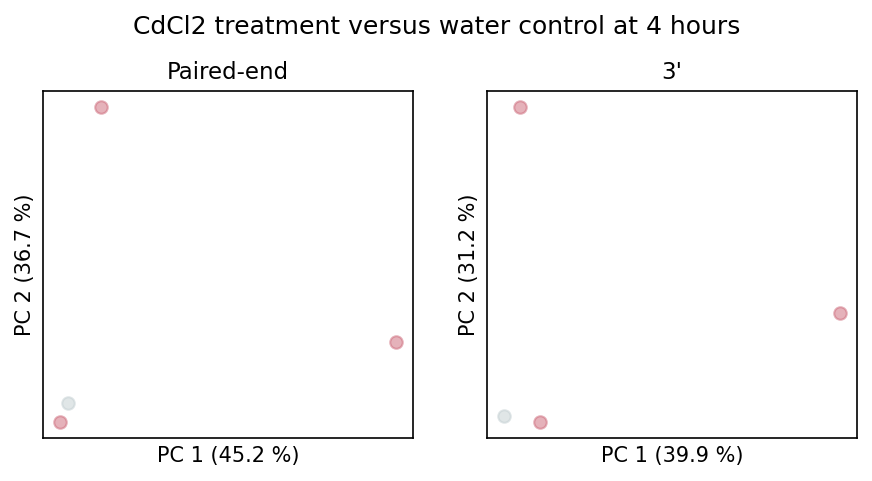

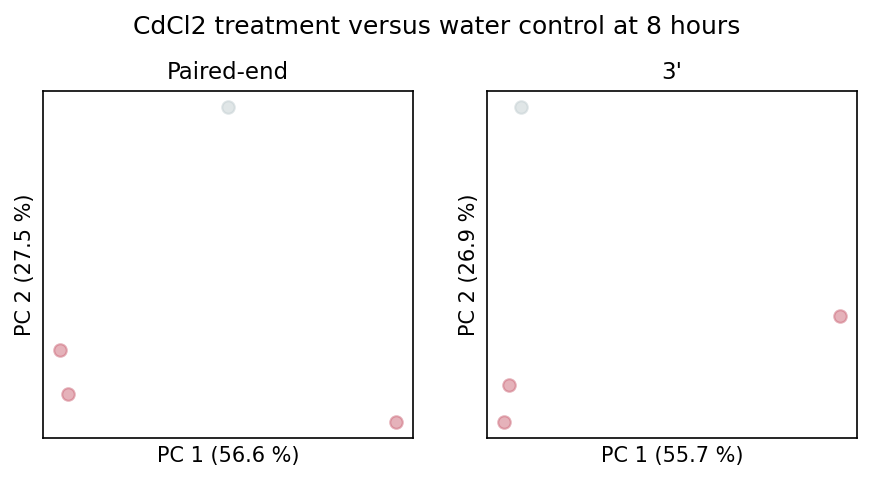

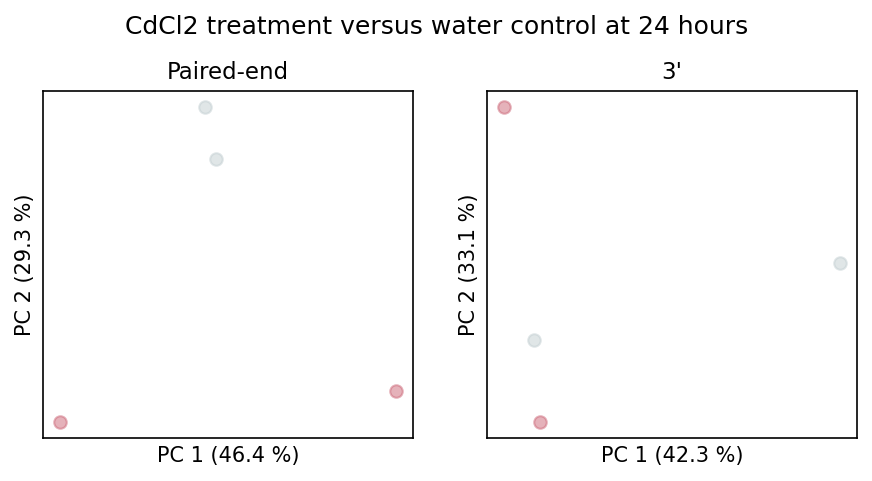

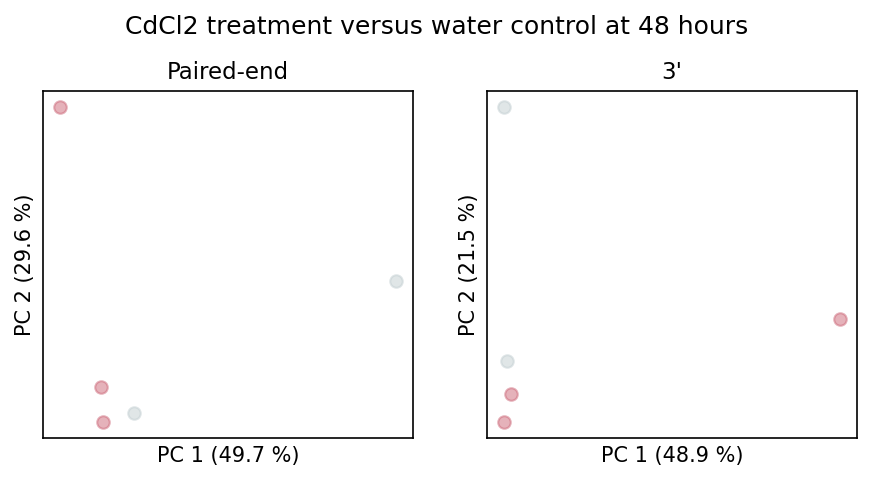

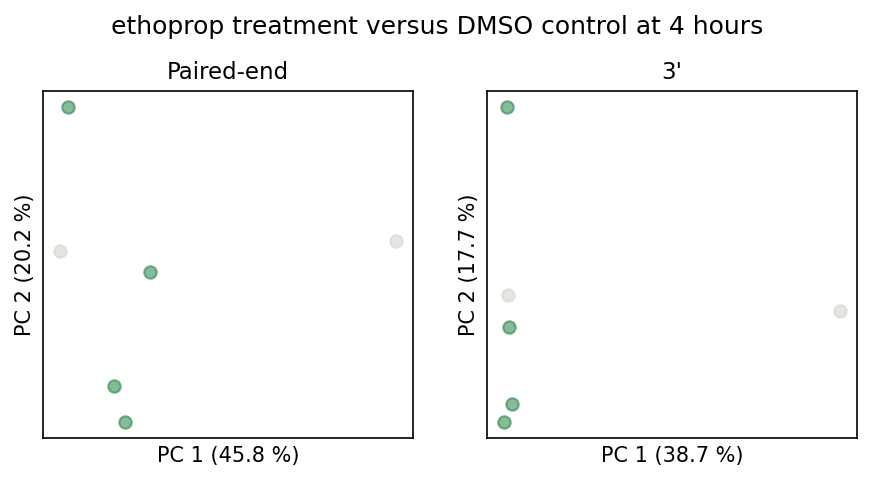

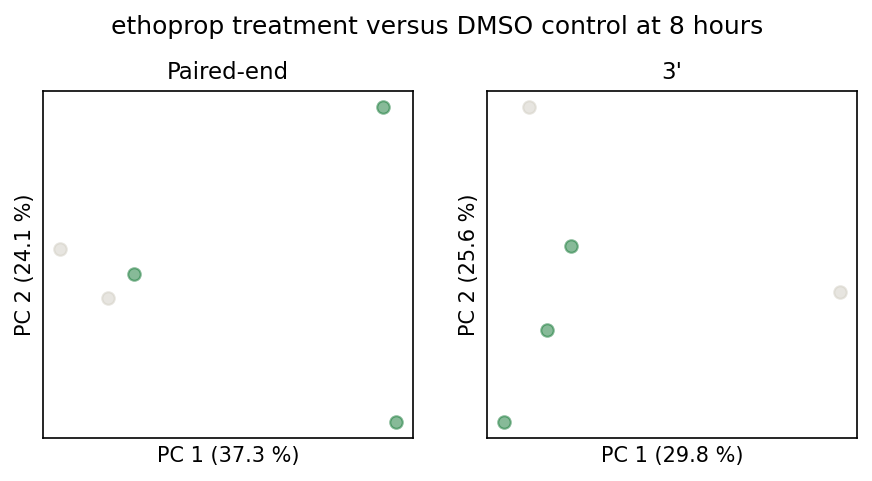

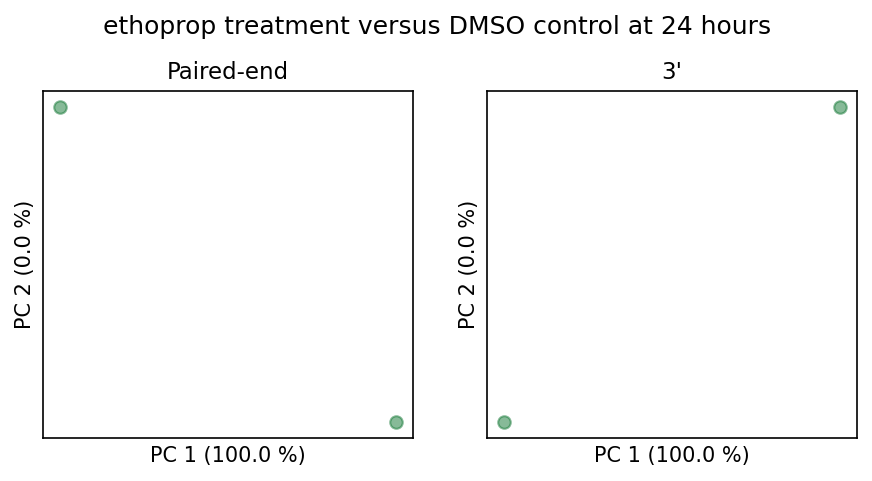

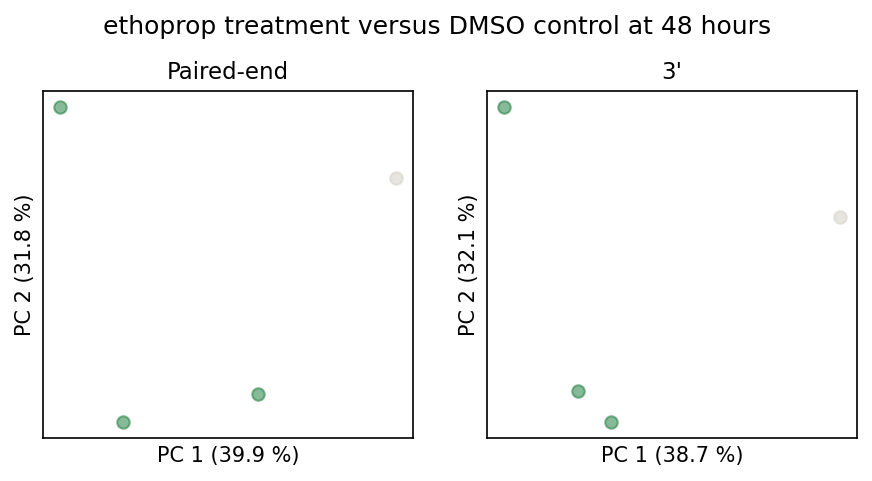

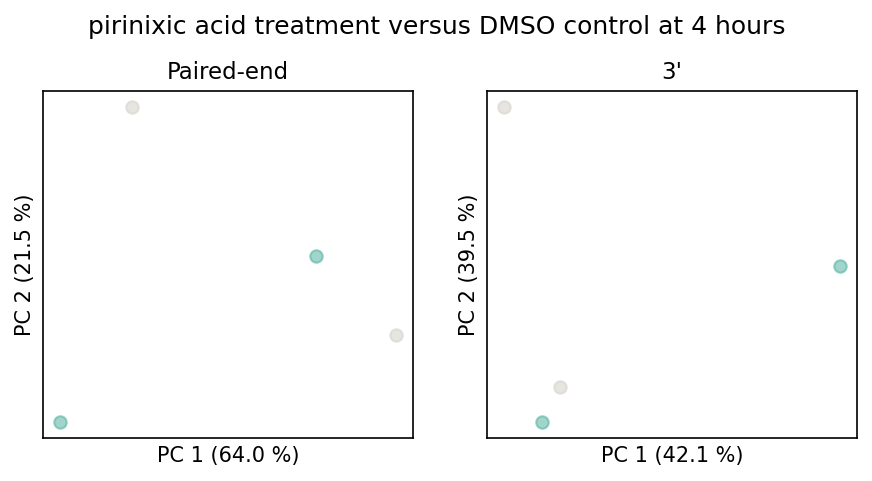

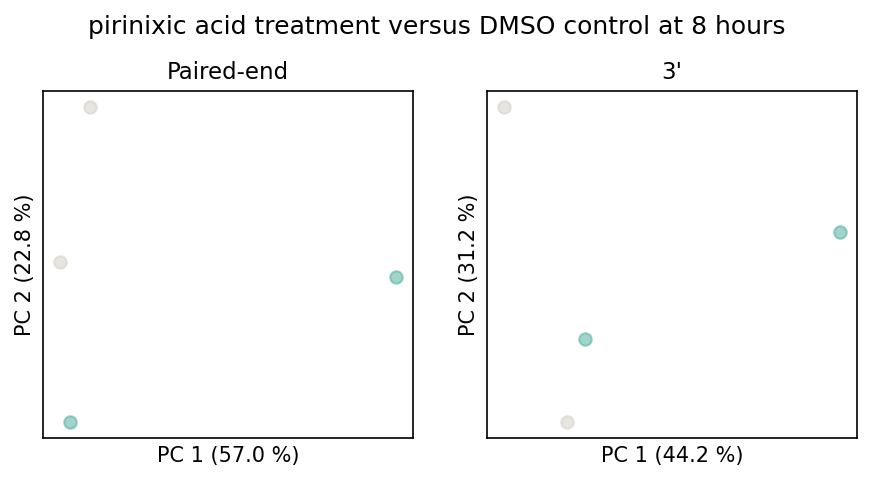

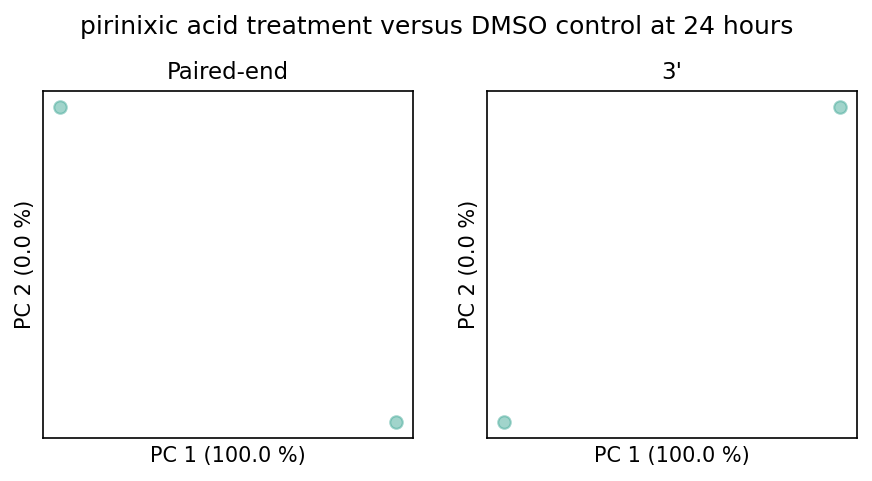

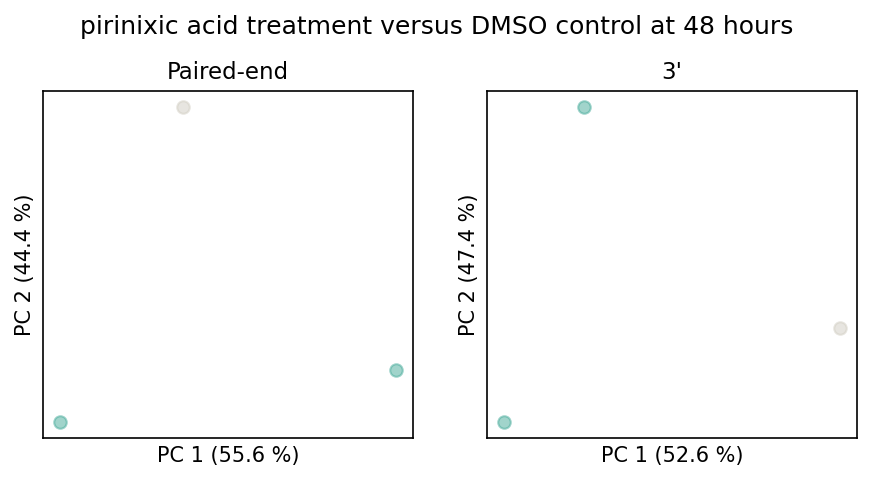

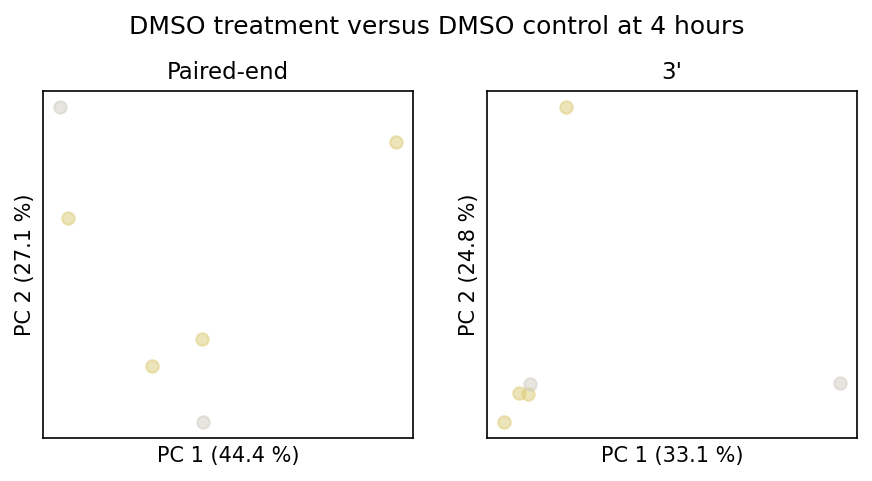

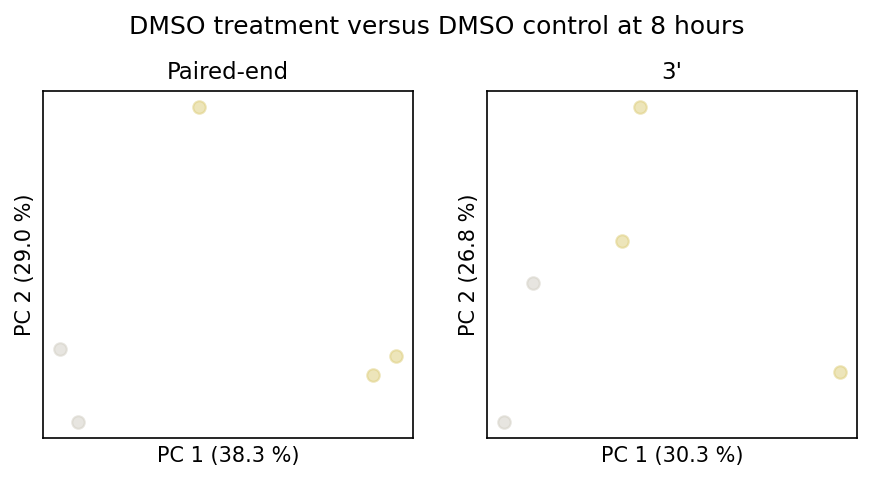

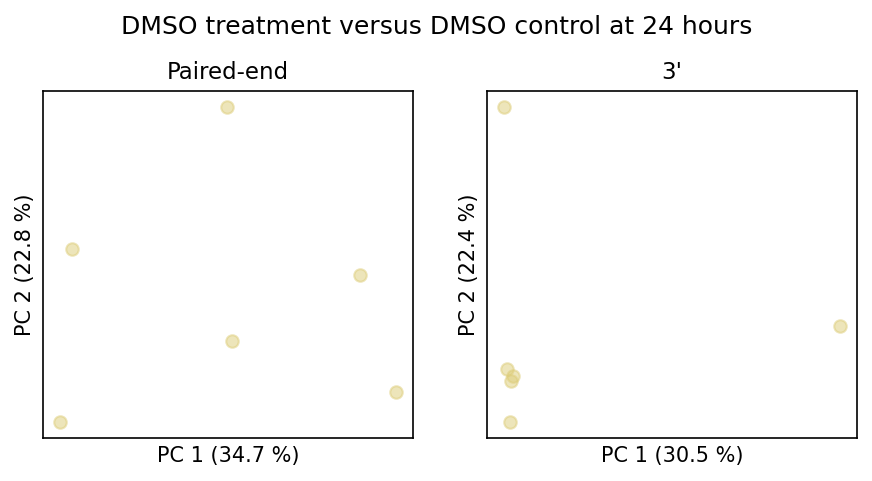

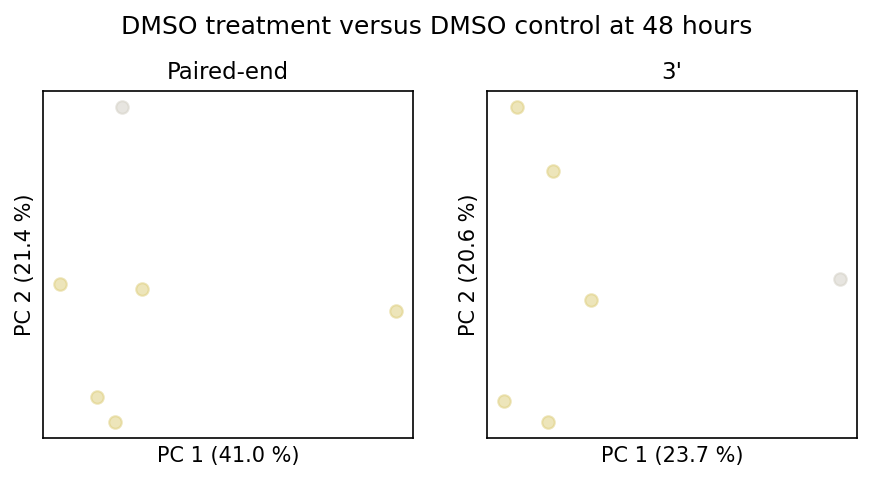

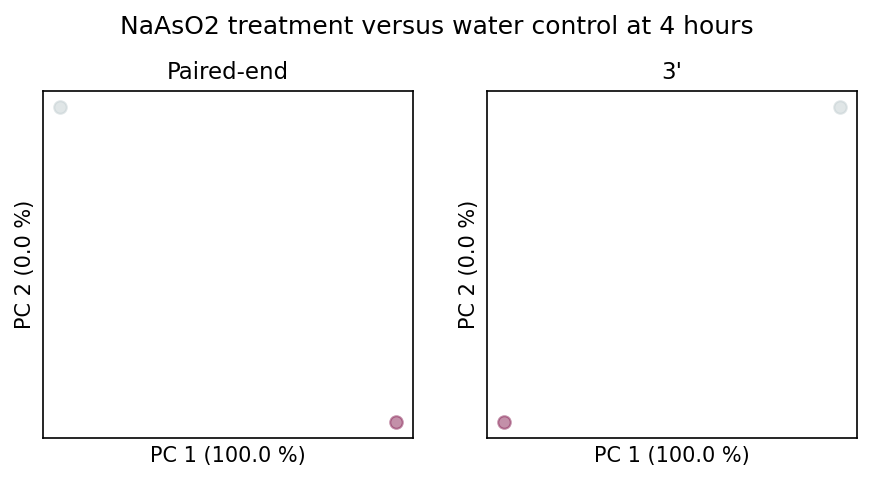

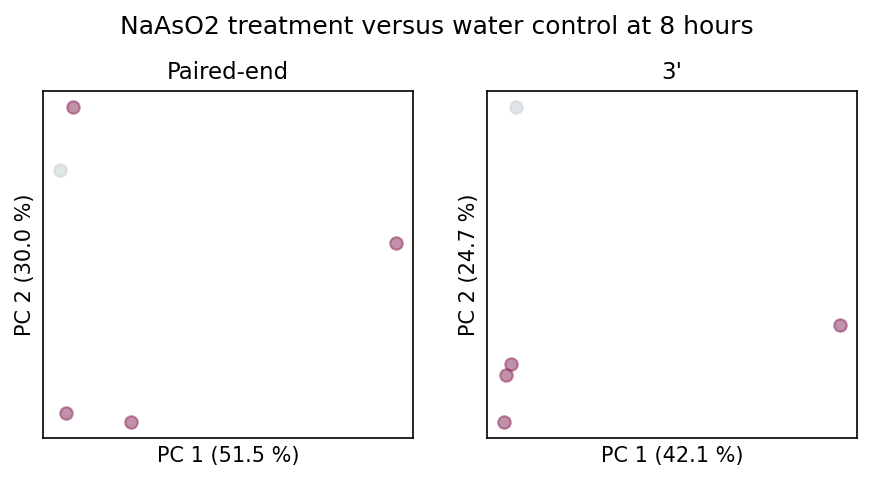

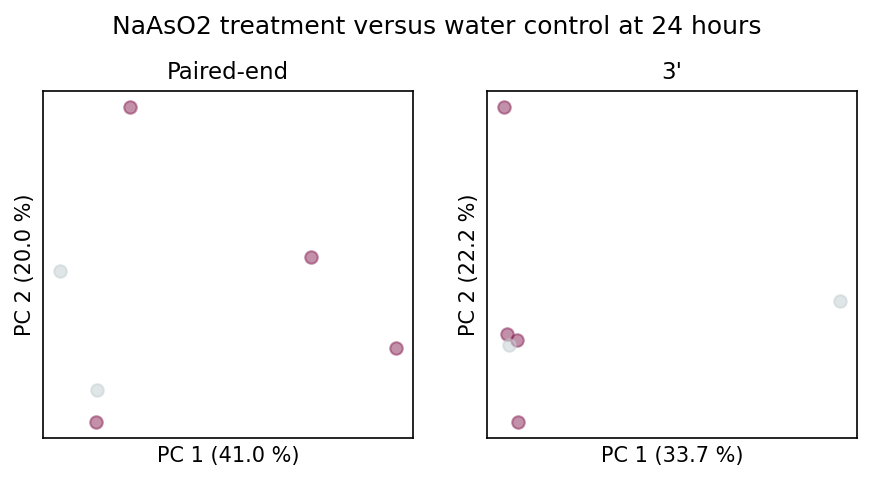

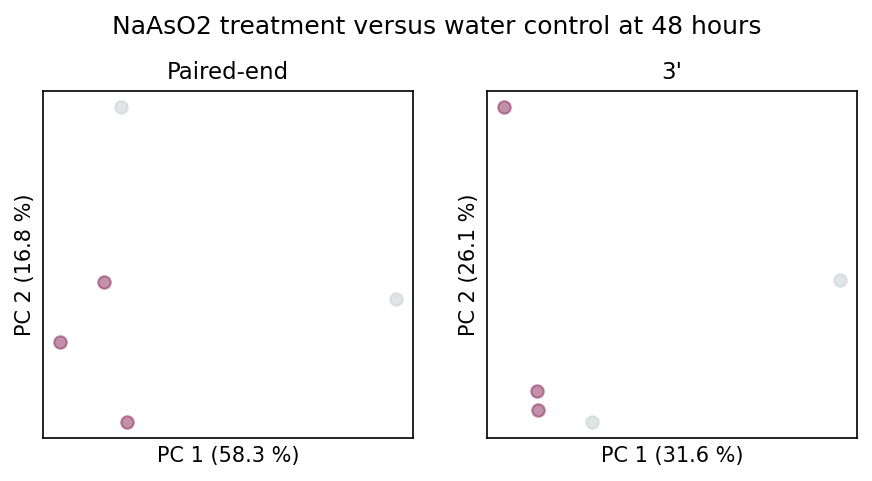

In [64]:
for t, c in controls.items():
    for tp, tph in tpmap.items():

        fig, axs = plt.subplots(1, 2, figsize=(7, 3),
                            dpi=150)

        tidx = [i for i in bgi.columns if (i[3:6] == t) & (i[7] == tp)]
        cidx = [i for i in bgi.columns if (i[3:6] == c) & (i[7] == tp)]
        idxs = tidx + cidx        
        bgi_pca = PCA(n_components=2).fit(bgi.loc[:, idxs].T)
        bgi_varexp = bgi_pca.explained_variance_ratio_
        bgi_pca = bgi_pca.transform(bgi.loc[:, idxs].T)
        bgi_pca = pd.DataFrame(bgi_pca, index=bgi.loc[:, idxs].columns, columns=['PC1', 'PC2'])
        axs[0].scatter(bgi_pca.loc[tidx, 'PC1'], bgi_pca.loc[tidx, 'PC2'],
                       edgecolor=colors[t], facecolor=colors[t],
                       label=t, alpha=.5)
        axs[0].scatter(bgi_pca.loc[cidx, 'PC1'], bgi_pca.loc[cidx, 'PC2'],
                       edgecolor=colors[c], facecolor=colors[c],
                       label=c, alpha=.5)
        axs[0].set_title('Paired-end', fontsize=11)
        axs[0].set_xlabel(f'PC 1 ({round(bgi_varexp[0] * 100, 1)} %)')
        axs[0].set_ylabel(f'PC 2 ({round(bgi_varexp[1] * 100, 1)} %)')

        
        tidx = [i for i in mgi.columns if (i[3:6] == t) & (i[7] == tp)]
        cidx = [i for i in mgi.columns if (i[3:6] == c) & (i[7] == tp)]
        idxs = tidx + cidx
        mgi_pca = PCA(n_components=2).fit(mgi.loc[:, idxs].T)
        mgi_varexp = mgi_pca.explained_variance_ratio_
        mgi_pca = mgi_pca.transform(mgi.loc[:, idxs].T)
        mgi_pca = pd.DataFrame(mgi_pca, index=mgi.loc[:, idxs].columns, columns=['PC1', 'PC2'])
        axs[1].scatter(mgi_pca.loc[tidx, 'PC1'], mgi_pca.loc[tidx, 'PC2'],
                       edgecolor=colors[t], facecolor=colors[t],
                       label=t, alpha=.5)
        axs[1].scatter(mgi_pca.loc[cidx, 'PC1'], mgi_pca.loc[cidx, 'PC2'],
                       edgecolor=colors[c], facecolor=colors[c],
                       label=c, alpha=.5)
        axs[1].set_title("3'", fontsize=11)
        axs[1].set_xlabel(f'PC 1 ({round(mgi_varexp[0] * 100, 1)} %)')
        axs[1].set_ylabel(f'PC 2 ({round(mgi_varexp[1] * 100, 1)} %)')
        
        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])
        plt.suptitle(f'{treatments[t]} versus {treatments[c]} at {tph} hours', y=1.05)
        plt.show()